# Nepse with PySpark and HDFS

This notebook demonstrates an end-to-end machine learning pipeline using PySpark and HDFS.

1. Setting up PySpark with Jupyter
2. Working with HDFS
3. Data preparation and feature engineering
4. Training a Linear Regression model
5. Model evaluation
6. Model persistence
7. Batch inference

## 1. Setup PySpark with Jupyter

First, let's initialize our PySpark session and verify the setup:

In [1]:
!python --version
# !pip uninstall -qy torch torchvision torchaudio
# !pip cache purge
!pip3 -q install torch==2.1.0+cpu -f https://download.pytorch.org/whl/torch_stable.html
!pip3 -q install --upgrade typing_extensions
!pip3 -q install transformers

Python 3.8.8


In [2]:
# from pyspark.sql import SparkSession

# # Initialize Spark session
# spark = SparkSession.builder \
#     .appName("HousingPricePrediction") \
#     .config("spark.master", "spark://spark-spark-1:7077") \
#     .getOrCreate()

# # Test the connection
# print("Spark WebUI URL:", spark.sparkContext.uiWebUrl)
# print("Spark Application ID:", spark.sparkContext.applicationId)
# print("Available cores:", spark.sparkContext.defaultParallelism)


from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("HousingPricePrediction") \
    .master("local[*]") \
    .getOrCreate()

print(spark.version)


3.1.1


## 2. Connect to HDFS and Load Data

Now we'll download the housing dataset and upload it to HDFS. We'll use the `hdfs` python library to interact with HDFS:

In [4]:
!pip install -q hdfs


# NEPSE

In [5]:
import os
import requests
import zipfile
from io import BytesIO

# URL of the dataset
url = "https://www.kaggle.com/api/v1/datasets/download/dinkarregmi/nepse-dataset"

# Path to save the zip file
zip_path = "nepse-dataset.zip"

# Download the file
print("Downloading dataset...")
response = requests.get(url, stream=True)
response.raise_for_status()  # Raise error if download fails

with open(zip_path, "wb") as f:
    for chunk in response.iter_content(chunk_size=8192):
        f.write(chunk)
print("Download complete!")

# Unzip the dataset
print("Extracting dataset...")
with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall(".")
print("Extraction complete!")

# Now you can access the folder
directory_path = "./By_Stock/By_Stock"
all_files = os.listdir(directory_path)

total_files = len(all_files)
print(f"Total number of files in '{directory_path}': {total_files}")

promoter_share_files = [f for f in all_files if "Promoter Share" in f]
print(f"Number of files containing 'Promoter Share': {len(promoter_share_files)}")

mutual_fund_files = [f for f in all_files if "Mutual Fund" in f]
print(f"Number of files containing 'Mutual Fund': {len(mutual_fund_files)}")

files_without_specific_terms = [
    f for f in all_files if "Promoter Share" not in f and "Mutual Fund" not in f
]
print(f"Number of files without 'Promoter Share' or 'Mutual Fund': {len(files_without_specific_terms)}")

# Example: load one CSV
import pandas as pd
df = pd.read_csv(os.path.join(directory_path, "SINDU.csv"))
df.head()

# Column mapping
col_name_mapping = {
    "No. Of Transaction": "totalTransactions",
    "Max Price": "highPrice",
    "Min Price": "lowPrice",
    "Closing Price": "closePrice",
    "Traded Shares": "totalTradeQuantity",
    "Previous Closing": "previousClose",
    "Difference Rs.": "change"
}


Download complete!
Extracting dataset...
Extraction complete!
Total number of files in './By_Stock/By_Stock': 588
Number of files containing 'Promoter Share': 143
Number of files containing 'Mutual Fund': 1
Number of files without 'Promoter Share' or 'Mutual Fund': 444


## Put data to HDFS

In [6]:
import os
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, to_date, year, month, lit
import re

# Initialize SparkSession
spark = SparkSession.builder \
    .appName("NEPSE_HDFS_Uploader") \
    .master("spark://spark-spark-1:7077") \
    .getOrCreate()

# Base HDFS path
hdfs_base_path = "/user/spark/NEPSE_data_parquet"

# Helper function to sanitize column names
def sanitize_column(name):
    name = re.sub(r"[ ,;{}()\n\t=]", "_", name)
    return name

# Function to upload all CSVs to HDFS in parallel using Spark
def upload_nepse_to_hdfs_spark(local_dir, hdfs_base_path=hdfs_base_path):
    # 1️⃣ Get all CSV file paths
    all_files = [os.path.join(local_dir, f) for f in os.listdir(local_dir) if f.endswith(".csv")]
    print(f"files {all_files[:5]}")
    if not all_files:
        print("No CSV files found.")
        return

    # 2️⃣ Read all CSVs together using Spark
    all_files = all_files[:5] # Limit to first 5 files for testing
    df = spark.read.option("header", True).csv(all_files)
    
    # 3️⃣ Sanitize columns
    for c in df.columns:
        df = df.withColumnRenamed(c, sanitize_column(c))
    
    # 4️⃣ Ensure Date column exists and parse
    if "Date" not in df.columns:
        raise ValueError("No 'Date' column found in CSVs")
    df = df.withColumn("Date", to_date(col("Date"), "yyyy-MM-dd"))
    df = df.filter(col("Date").isNotNull())

    # 5️⃣ Extract year/month
    df = df.withColumn("year", year(col("Date"))) \
           .withColumn("month", month(col("Date")))
    
    # 6️⃣ Extract stock_symbol from file paths
    # Since we read all CSVs together, create a mapping from path to stock symbol
    file_to_symbol = {os.path.join(local_dir, f): f.replace(".csv","") for f in os.listdir(local_dir) if f.endswith(".csv")}
    
    # Add stock_symbol column based on input_file_name()
    from pyspark.sql.functions import input_file_name
    df = df.withColumn("input_file", input_file_name())
    
    # Map full path to stock_symbol
    mapping_expr = df.select("input_file").distinct().rdd.map(lambda r: (r[0], os.path.basename(r[0]).replace(".csv",""))).collectAsMap()
    mapping_broadcast = spark.sparkContext.broadcast(mapping_expr)
    
    from pyspark.sql.functions import udf
    from pyspark.sql.types import StringType

    def get_symbol(file_path):
        return mapping_broadcast.value.get(file_path, "UNKNOWN")
    
    get_symbol_udf = udf(get_symbol, StringType())
    df = df.withColumn("stock_symbol", get_symbol_udf(col("input_file"))).drop("input_file")

    # 7️⃣ Repartition for parallel writes
    df = df.repartition("stock_symbol", "year", "month")

    # 8️⃣ Write once to HDFS in partitioned Parquet format
    df.write.mode("append").partitionBy("stock_symbol", "year", "month") \
          .parquet(f"hdfs://namenode:9000{hdfs_base_path}")
    
    print(f"All NEPSE CSV files uploaded successfully to HDFS at {hdfs_base_path}!")

# Usage
local_dir = "./By_Stock/By_Stock"
upload_nepse_to_hdfs_spark(local_dir)


files ['./By_Stock/By_Stock/SANIMA.csv', './By_Stock/By_Stock/BFC.csv', './By_Stock/By_Stock/NBF3.csv', './By_Stock/By_Stock/PPCL.csv', './By_Stock/By_Stock/Reliable Development Bank Ltd. Promoter Share.csv']
All NEPSE CSV files uploaded successfully to HDFS at /user/spark/NEPSE_data_parquet!


In [7]:
from pyspark.sql import SparkSession
from py4j.java_gateway import java_import

# 1️⃣ Create SparkSession with proper HDFS config
spark = SparkSession.builder \
    .appName("NEPSE HDFS Analysis") \
    .config("spark.hadoop.fs.defaultFS", "hdfs://namenode:9000") \
    .getOrCreate()

# 2️⃣ Import Hadoop Path and FileSystem classes
java_import(spark._jvm, "org.apache.hadoop.fs.Path")
java_import(spark._jvm, "org.apache.hadoop.fs.FileSystem")

# 3️⃣ Explicitly get HDFS FileSystem
hadoop_conf = spark._jsc.hadoopConfiguration()
hdfs_uri = spark._jvm.java.net.URI("hdfs://namenode:9000")
fs = spark._jvm.FileSystem.get(hdfs_uri, hadoop_conf)

# 4️⃣ Base HDFS path for NEPSE dataset
base_path = spark._jvm.Path(hdfs_base_path)

# 5️⃣ Function to list directories in HDFS path
def list_hdfs_dirs(path):
    status = fs.listStatus(path)
    dirs = [s.getPath().getName() for s in status if s.isDirectory()]
    return dirs

# 6️⃣ List all stock symbols available
stocks_available = list_hdfs_dirs(base_path)
print("Stocks available in HDFS:", stocks_available)

# 7️⃣ Pick the first stock to see available years
if stocks_available:
    stock = stocks_available[0]
    stock_path = spark._jvm.Path(f"{hdfs_base_path}/{stock}")
    years_available = list_hdfs_dirs(stock_path)
    print(f"Years available for {stock}:", [y.replace("year=", "") for y in years_available])

    # 8️⃣ Pick the first year to see available months
    if years_available:
        year = years_available[0].replace("year=", "")
        year_path = spark._jvm.Path(f"{hdfs_base_path}/{stock}/{years_available[0]}")
        months_available = list_hdfs_dirs(year_path)
        print(f"Months available for {stock} {year}:", [m.replace("month=", "") for m in months_available])


Stocks available in HDFS: ['models', 'stock_symbol=BFC', 'stock_symbol=NBF3', 'stock_symbol=PPCL', 'stock_symbol=Reliable%2520Development%2520Bank%2520Ltd.%2520Promoter%2520Share', 'stock_symbol=SANIMA']
Years available for models: ['lstm']
Months available for models lstm: ['BFC']


In [8]:
print(f"reading data from: {hdfs_base_path}")

try:
    # 1. read the entire partitioned parquet dataset from hdfs
    # spark automatically handles the partitioning
    df_hdfs = spark.read.parquet(hdfs_base_path)

    # 2. show the schema of the dataframe to see column names and types
    print("schema of the uploaded data:")
    df_hdfs.printSchema()

    # 3. show a few sample rows to inspect the actual data
    print("\nsample data from hdfs:")
    df_hdfs.show(5, truncate=False) # show 5 rows, don't truncate long strings

    # optional: count total rows to get a sense of data volume
    row_count = df_hdfs.count()
    print(f"\ntotal number of rows in the hdfs dataset: {row_count}")

except Exception as e:
    print(f"error reading data from hdfs: {e}")
    print("please ensure the hdfs_base_path is correct and contains parquet files.")

# HDFS path for your stock
stock_symbol = "BFC"




stock_path = spark._jvm.Path(f"{hdfs_base_path}/stock_symbol={stock_symbol}")


# List available years for NMB50
years_available = list_hdfs_dirs(stock_path)
print(f"Years available for {stock_symbol}:", [y.replace("year=", "") for y in years_available])

# List months for each available year
for year_dir in years_available:
    year = year_dir.replace("year=", "")
    year_path = spark._jvm.Path(f"{hdfs_base_path}/stock_symbol={stock_symbol}/{year_dir}")
    months_available = list_hdfs_dirs(year_path)
    print(f"Months available for {stock_symbol} {year}:", [m.replace("month=", "") for m in months_available])

reading data from: /user/spark/NEPSE_data_parquet
error reading data from hdfs: Path does not exist: file:/user/spark/NEPSE_data_parquet
please ensure the hdfs_base_path is correct and contains parquet files.
Years available for BFC: ['2012', '2017', '2018', '2019', '2020', '2021', '2022']
Months available for BFC 2012: ['9']
Months available for BFC 2017: ['10', '11', '12', '7', '8', '9']
Months available for BFC 2018: ['1', '10', '12', '2', '3', '4', '5', '6', '7', '8', '9']
Months available for BFC 2019: ['1', '10', '11', '12', '2', '3', '4', '5', '6', '7', '8', '9']
Months available for BFC 2020: ['1', '10', '11', '12', '2', '3', '5', '6', '7', '8', '9']
Months available for BFC 2021: ['1', '10', '11', '12', '2', '3', '4', '5', '6', '7', '8', '9']
Months available for BFC 2022: ['1', '2', '3', '4', '5', '6', '7']


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from typing import List, Dict, Tuple, Callable
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# DATA LOADING & PREPROCESSING
# ============================================================================

def load_stock_data_from_hdfs(spark, hdfs_base_path: str, stock_symbol: str, 
                               start_year: int = None, end_year: int = None) -> pd.DataFrame:
    """
    Load stock data from HDFS for a specific symbol.
    """
    print(f"Loading data for {stock_symbol}...")
    
    # Build the path
    if start_year and end_year:
        # Load specific year range
        all_data = []
        for year in range(start_year, end_year + 1):
            try:
                year_path = f"hdfs://namenode:9000{hdfs_base_path}/stock_symbol={stock_symbol}/year={year}"
                df_year = spark.read.parquet(year_path).toPandas()
                all_data.append(df_year)
                print(f"  Loaded year {year}: {len(df_year)} rows")
            except Exception as e:
                print(f"  Year {year} not found or error: {e}")
        
        if not all_data:
            print("No data found!")
            return pd.DataFrame()
        
        df = pd.concat(all_data, ignore_index=True)
    else:
        # Load all available data
        stock_path = f"{hdfs_base_path}/stock_symbol={stock_symbol}"
        df = spark.read.parquet(stock_path).toPandas()
    
    # Clean and convert columns
    print(f"Total rows loaded: {len(df)}")
    
    # Convert string columns to float
    numeric_cols = ['Max_Price', 'Min_Price', 'Closing_Price', 'Traded_Shares', 
                    'Amount', 'Previous_Closing', 'No._Of_Transaction']
    
    for col in numeric_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
    
    # Ensure Date is datetime
    df['Date'] = pd.to_datetime(df['Date'])
    
    # Sort by date
    df = df.sort_values('Date').reset_index(drop=True)
    
    # Rename columns to standard OHLC format
    df = df.rename(columns={
        'Date': 'date',
        'Max_Price': 'high',
        'Min_Price': 'low',
        'Closing_Price': 'close',
        'Previous_Closing': 'open'  # Using previous closing as open
    })
    
    # If open is not available or is NaN, use the close from previous day
    if 'open' not in df.columns or df['open'].isna().all():
        df['open'] = df['close'].shift(1)
        df.loc[0, 'open'] = df.loc[0, 'close']  # First day: open = close
    
    # Drop rows with missing critical data
    df = df.dropna(subset=['date', 'open', 'high', 'low', 'close'])
    
    print(f"After cleaning: {len(df)} rows")
    print(f"Date range: {df['date'].min()} to {df['date'].max()}")
    
    return df


# ============================================================================
# PATTERN DETECTION FUNCTION (DAILY DATA ONLY)
# ============================================================================

def detect_fvg_choch_pattern(daily_df: pd.DataFrame, idx: int) -> Dict:
    """
    Detect pattern with (adapted for daily data):
    1. Bullish candle
    2. FVG formation (no overlap between 1st and 3rd candle)
    3. Change of Character (CHoCH) in DAILY timeframe (not hourly)
    4. Order Block identification
    
    Args:
        daily_df: Daily timeframe data
        idx: Current index in daily_df
        
    Returns:
        Dict with 'signal': bool, 'entry_price': float, 'stop_loss': float, 
        'take_profit': float, 'details': dict
    """
    
    # Need at least 20 candles for proper CHoCH detection
    if idx < 20:
        return {'signal': False}
    
    # Get the three candles for FVG
    candle1 = daily_df.iloc[idx - 2]
    candle2 = daily_df.iloc[idx - 1]
    candle3 = daily_df.iloc[idx]
    
    # 1. Check if current candle is BULLISH
    is_bullish = candle3['close'] > candle3['open']
    if not is_bullish:
        return {'signal': False}
    
    # 2. Check for FVG (Fair Value Gap)
    # FVG exists when there's no overlap between candle1 high and candle3 low
    candle1_high = candle1['high']
    candle3_low = candle3['low']
    
    # For bullish FVG: candle1 high < candle3 low (gap up)
    has_fvg = candle1_high < candle3_low
    
    if not has_fvg:
        return {'signal': False}
    
    fvg_low = candle1_high
    fvg_high = candle3_low
    
    # 3. Check for Change of Character (CHoCH) in DAILY timeframe
    # Look at previous 20 days to detect structure break
    lookback_window = daily_df.iloc[max(0, idx-20):idx]
    
    has_choch = detect_choch_daily(lookback_window)
    
    if not has_choch:
        return {'signal': False}
    
    # 4. Identify Order Block
    order_block = identify_order_block(daily_df, idx)
    
    if order_block is None:
        return {'signal': False}
    
    # Define entry, stop loss, and take profit
    entry_price = candle3['close']
    stop_loss = order_block['low'] * 0.98  # 2% below order block
    
    # Risk-reward ratio of 1:2
    risk = entry_price - stop_loss
    take_profit = entry_price + (risk * 2)
    
    return {
        'signal': True,
        'entry_price': entry_price,
        'stop_loss': stop_loss,
        'take_profit': take_profit,
        'details': {
            'fvg_low': fvg_low,
            'fvg_high': fvg_high,
            'order_block_low': order_block['low'],
            'order_block_high': order_block['high'],
            'entry_date': candle3['date']
        }
    }


def detect_choch_daily(df: pd.DataFrame) -> bool:
    """
    Detect Change of Character in DAILY timeframe.
    CHoCH = Price breaks above a previous swing high after making a swing low
    
    This indicates a bullish structure break (change from bearish to bullish)
    """
    if len(df) < 10:
        return False
    
    lows = df['low'].values
    highs = df['high'].values
    
    # Find swing lows and swing highs
    swing_lows = []
    swing_highs = []
    
    # Identify swing lows (local minimums)
    for i in range(2, len(lows) - 2):
        if (lows[i] < lows[i-1] and lows[i] < lows[i-2] and 
            lows[i] < lows[i+1] and lows[i] < lows[i+2]):
            swing_lows.append((i, lows[i]))
    
    # Identify swing highs (local maximums)
    for i in range(2, len(highs) - 2):
        if (highs[i] > highs[i-1] and highs[i] > highs[i-2] and 
            highs[i] > highs[i+1] and highs[i] > highs[i+2]):
            swing_highs.append((i, highs[i]))
    
    # CHoCH occurs when:
    # 1. We make a swing low
    # 2. Then price breaks above a previous swing high
    if len(swing_lows) > 0 and len(swing_highs) > 0:
        # Get the most recent swing low
        last_swing_low_idx, last_swing_low = swing_lows[-1]
        
        # Find swing highs that occurred BEFORE the last swing low
        previous_swing_highs = [sh for sh in swing_highs if sh[0] < last_swing_low_idx]
        
        if previous_swing_highs:
            # Get the highest swing high before the swing low
            target_swing_high = max(previous_swing_highs, key=lambda x: x[1])[1]
            
            # Check if recent prices broke above that swing high
            recent_highs = highs[last_swing_low_idx:]
            if any(h > target_swing_high for h in recent_highs):
                return True
    
    return False


def identify_order_block(df: pd.DataFrame, idx: int) -> Dict:
    """
    Identify order block - the last bearish candle before the bullish move.
    Order blocks represent areas where institutions placed orders.
    """
    lookback = min(10, idx)
    
    for i in range(1, lookback + 1):
        candle = df.iloc[idx - i]
        # Bearish candle (close < open)
        if candle['close'] < candle['open']:
            return {
                'low': candle['low'],
                'high': candle['high'],
                'open': candle['open'],
                'close': candle['close']
            }
    
    return None


# ============================================================================
# BACKTESTING ENGINE (GENERIC)
# ============================================================================

def backtest_pattern(daily_df: pd.DataFrame, pattern_func: Callable, 
                     max_hold_days: int = 30) -> List[Dict]:
    """
    Generic backtesting function that works with any pattern detection function.
    
    Args:
        daily_df: Daily OHLCV data
        pattern_func: Function that takes (daily_df, idx) and returns signal dict
        max_hold_days: Maximum days to hold position
        
    Returns:
        List of trade results
    """
    trades = []
    
    print(f"\nScanning {len(daily_df)} days for pattern...")
    
    # Scan through historical data
    for i in range(len(daily_df)):
        if i % 100 == 0:
            print(f"  Progress: {i}/{len(daily_df)} days scanned, {len(trades)} signals found")
        
        # Detect pattern
        signal = pattern_func(daily_df, i)
        
        if not signal.get('signal', False):
            continue
        
        entry_price = signal['entry_price']
        stop_loss = signal['stop_loss']
        take_profit = signal['take_profit']
        entry_date = daily_df.iloc[i]['date']
        
        # Simulate trade execution
        exit_price = None
        exit_date = None
        exit_reason = None
        
        # Look forward to see what happens
        for j in range(i + 1, min(i + max_hold_days + 1, len(daily_df))):
            candle = daily_df.iloc[j]
            
            # Check if stop loss hit
            if candle['low'] <= stop_loss:
                exit_price = stop_loss
                exit_date = candle['date']
                exit_reason = 'stop_loss'
                break
            
            # Check if take profit hit
            if candle['high'] >= take_profit:
                exit_price = take_profit
                exit_date = candle['date']
                exit_reason = 'take_profit'
                break
        
        # If no exit, close at end of holding period
        if exit_price is None:
            exit_idx = min(i + max_hold_days, len(daily_df) - 1)
            exit_price = daily_df.iloc[exit_idx]['close']
            exit_date = daily_df.iloc[exit_idx]['date']
            exit_reason = 'max_hold'
        
        # Calculate returns
        pnl = exit_price - entry_price
        pnl_pct = (pnl / entry_price) * 100
        
        trades.append({
            'entry_date': entry_date,
            'exit_date': exit_date,
            'entry_price': entry_price,
            'exit_price': exit_price,
            'stop_loss': stop_loss,
            'take_profit': take_profit,
            'pnl': pnl,
            'pnl_pct': pnl_pct,
            'exit_reason': exit_reason,
            'details': signal.get('details', {})
        })
    
    print(f"\nBacktest complete! Found {len(trades)} total signals")
    return trades


# ============================================================================
# VISUALIZATION (GENERIC)
# ============================================================================

def visualize_backtest_results(trades: List[Dict], stock_symbol: str, daily_df: pd.DataFrame = None):
    """
    Create comprehensive visualizations of backtest results.
    
    Args:
        trades: List of trade dictionaries
        stock_symbol: Stock symbol for the title
        daily_df: Optional daily price data for interactive chart
    """
    if not trades:
        print("No trades found!")
        return None
    
    df_trades = pd.DataFrame(trades)
    
    # Calculate metrics
    total_trades = len(df_trades)
    winning_trades = len(df_trades[df_trades['pnl'] > 0])
    losing_trades = len(df_trades[df_trades['pnl'] <= 0])
    win_rate = (winning_trades / total_trades) * 100 if total_trades > 0 else 0
    
    avg_win = df_trades[df_trades['pnl'] > 0]['pnl_pct'].mean() if winning_trades > 0 else 0
    avg_loss = df_trades[df_trades['pnl'] <= 0]['pnl_pct'].mean() if losing_trades > 0 else 0
    
    total_return = df_trades['pnl_pct'].sum()
    avg_return = df_trades['pnl_pct'].mean()
    
    # Create figure with subplots
    fig = plt.figure(figsize=(20, 12))
    gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)
    
    # 1. Win/Loss Distribution
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.pie([winning_trades, losing_trades], 
            labels=['Winning', 'Losing'],
            autopct='%1.1f%%',
            colors=['#2ecc71', '#e74c3c'],
            startangle=90)
    ax1.set_title(f'Win Rate: {win_rate:.1f}%\n({winning_trades}W / {losing_trades}L)', 
                  fontsize=12, fontweight='bold')
    
    # 2. PnL Distribution
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.hist(df_trades['pnl_pct'], bins=30, color='#3498db', alpha=0.7, edgecolor='black')
    ax2.axvline(0, color='red', linestyle='--', linewidth=2)
    ax2.set_xlabel('Return (%)')
    ax2.set_ylabel('Frequency')
    ax2.set_title('Distribution of Returns', fontsize=12, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    
    # 3. Cumulative Returns
    ax3 = fig.add_subplot(gs[0, 2])
    df_trades['cumulative_return'] = df_trades['pnl_pct'].cumsum()
    ax3.plot(df_trades['cumulative_return'], linewidth=2, color='#9b59b6')
    ax3.fill_between(range(len(df_trades)), df_trades['cumulative_return'], 
                      alpha=0.3, color='#9b59b6')
    ax3.set_xlabel('Trade Number')
    ax3.set_ylabel('Cumulative Return (%)')
    ax3.set_title(f'Cumulative Returns: {total_return:.2f}%', fontsize=12, fontweight='bold')
    ax3.grid(True, alpha=0.3)
    ax3.axhline(0, color='red', linestyle='--', linewidth=1)
    
    # 4. Returns by Exit Reason
    ax4 = fig.add_subplot(gs[1, 0])
    exit_reasons = df_trades.groupby('exit_reason')['pnl_pct'].mean().sort_values()
    colors_exit = ['#2ecc71' if x > 0 else '#e74c3c' for x in exit_reasons.values]
    exit_reasons.plot(kind='barh', ax=ax4, color=colors_exit)
    ax4.set_xlabel('Average Return (%)')
    ax4.set_title('Avg Return by Exit Reason', fontsize=12, fontweight='bold')
    ax4.grid(True, alpha=0.3, axis='x')
    
    # 5. Monthly Performance
    ax5 = fig.add_subplot(gs[1, 1])
    df_trades['entry_month'] = pd.to_datetime(df_trades['entry_date']).dt.to_period('M')
    monthly_returns = df_trades.groupby('entry_month')['pnl_pct'].sum()
    colors_monthly = ['#2ecc71' if x > 0 else '#e74c3c' for x in monthly_returns.values]
    monthly_returns.plot(kind='bar', ax=ax5, color=colors_monthly)
    ax5.set_xlabel('Month')
    ax5.set_ylabel('Total Return (%)')
    ax5.set_title('Monthly Performance', fontsize=12, fontweight='bold')
    ax5.grid(True, alpha=0.3, axis='y')
    ax5.tick_params(axis='x', rotation=45)
    
    # 6. Winning vs Losing Trade Stats
    ax6 = fig.add_subplot(gs[1, 2])
    stats_data = [avg_win, abs(avg_loss)]
    bars = ax6.bar(['Avg Win', 'Avg Loss'], stats_data, color=['#2ecc71', '#e74c3c'])
    ax6.set_ylabel('Average Return (%)')
    ax6.set_title('Win/Loss Comparison', fontsize=12, fontweight='bold')
    ax6.grid(True, alpha=0.3, axis='y')
    for bar in bars:
        height = bar.get_height()
        ax6.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}%', ha='center', va='bottom', fontweight='bold')
    
    # 7. Trade Duration Analysis
    ax7 = fig.add_subplot(gs[2, 0])
    df_trades['duration'] = (pd.to_datetime(df_trades['exit_date']) - 
                             pd.to_datetime(df_trades['entry_date'])).dt.days
    ax7.scatter(df_trades['duration'], df_trades['pnl_pct'], 
               c=df_trades['pnl_pct'], cmap='RdYlGn', alpha=0.6, s=50)
    ax7.set_xlabel('Trade Duration (days)')
    ax7.set_ylabel('Return (%)')
    ax7.set_title('Duration vs Returns', fontsize=12, fontweight='bold')
    ax7.grid(True, alpha=0.3)
    ax7.axhline(0, color='black', linestyle='--', linewidth=1)
    
    # 8. Summary Statistics Table
    ax8 = fig.add_subplot(gs[2, 1:])
    ax8.axis('off')
    
    summary_stats = [
        ['Total Trades', f'{total_trades}'],
        ['Win Rate', f'{win_rate:.2f}%'],
        ['Total Return', f'{total_return:.2f}%'],
        ['Avg Return/Trade', f'{avg_return:.2f}%'],
        ['Avg Win', f'{avg_win:.2f}%'],
        ['Avg Loss', f'{avg_loss:.2f}%'],
        ['Best Trade', f'{df_trades["pnl_pct"].max():.2f}%'],
        ['Worst Trade', f'{df_trades["pnl_pct"].min():.2f}%'],
        ['Profit Factor', f'{abs(avg_win/avg_loss):.2f}' if avg_loss != 0 else 'N/A']
    ]
    
    table = ax8.table(cellText=summary_stats, 
                     colLabels=['Metric', 'Value'],
                     cellLoc='left',
                     loc='center',
                     colWidths=[0.4, 0.3])
    table.auto_set_font_size(False)
    table.set_fontsize(11)
    table.scale(1, 2.5)
    
    # Style table
    for i in range(len(summary_stats) + 1):
        for j in range(2):
            cell = table[(i, j)]
            if i == 0:
                cell.set_facecolor('#34495e')
                cell.set_text_props(weight='bold', color='white')
            else:
                cell.set_facecolor('#ecf0f1' if i % 2 == 0 else 'white')
    
    plt.suptitle(f'{stock_symbol} - Pattern Backtest Results', 
                fontsize=16, fontweight='bold', y=0.995)
    
    plt.show()
    
    # Create interactive price chart with signals if daily_df provided
    if daily_df is not None:
        print("\n" + "="*80)
        print("INTERACTIVE PRICE CHART WITH PATTERN SIGNALS")
        print("="*80)
        create_interactive_price_chart(daily_df, df_trades, stock_symbol)
    
    return df_trades


def create_interactive_price_chart(daily_df: pd.DataFrame, df_trades: pd.DataFrame, stock_symbol: str):
    """
    Create an interactive plotly chart showing price action with buy/sell signals.
    
    Args:
        daily_df: Daily OHLCV data
        df_trades: DataFrame with trade results
        stock_symbol: Stock symbol for the title
    """
    try:
        import plotly.graph_objects as go
        from plotly.subplots import make_subplots
    except ImportError:
        print("Installing plotly for interactive charts...")
        import subprocess
        subprocess.check_call(['pip', 'install', '-q', 'plotly'])
        import plotly.graph_objects as go
        from plotly.subplots import make_subplots
    
    # Create figure with secondary y-axis
    fig = make_subplots(
        rows=2, cols=1,
        shared_xaxes=True,
        vertical_spacing=0.03,
        row_heights=[0.7, 0.3],
        subplot_titles=(f'{stock_symbol} - Price Action with Pattern Signals', 'Trade P&L %')
    )
    
    # Add candlestick chart
    fig.add_trace(
        go.Candlestick(
            x=daily_df['date'],
            open=daily_df['open'],
            high=daily_df['high'],
            low=daily_df['low'],
            close=daily_df['close'],
            name='Price',
            increasing_line_color='#2ecc71',
            decreasing_line_color='#e74c3c'
        ),
        row=1, col=1
    )
    
    # Add buy signals (entry points)
    entry_dates = pd.to_datetime(df_trades['entry_date'])
    entry_prices = df_trades['entry_price']
    
    fig.add_trace(
        go.Scatter(
            x=entry_dates,
            y=entry_prices,
            mode='markers',
            name='Entry Signal',
            marker=dict(
                symbol='triangle-up',
                size=12,
                color='#3498db',
                line=dict(width=2, color='white')
            ),
            text=[f"Entry: {p:.2f}" for p in entry_prices],
            hovertemplate='<b>Entry Signal</b><br>Date: %{x}<br>Price: %{y:.2f}<extra></extra>'
        ),
        row=1, col=1
    )
    
    # Add exit signals
    exit_dates = pd.to_datetime(df_trades['exit_date'])
    exit_prices = df_trades['exit_price']
    exit_colors = ['#2ecc71' if pnl > 0 else '#e74c3c' for pnl in df_trades['pnl']]
    
    fig.add_trace(
        go.Scatter(
            x=exit_dates,
            y=exit_prices,
            mode='markers',
            name='Exit Signal',
            marker=dict(
                symbol='triangle-down',
                size=12,
                color=exit_colors,
                line=dict(width=2, color='white')
            ),
            text=[f"Exit: {p:.2f}<br>P&L: {pnl:.2f}%" 
                  for p, pnl in zip(exit_prices, df_trades['pnl_pct'])],
            hovertemplate='<b>Exit Signal</b><br>Date: %{x}<br>Price: %{y:.2f}<br>%{text}<extra></extra>'
        ),
        row=1, col=1
    )
    
    # Add lines connecting entry and exit
    for idx, row in df_trades.iterrows():
        color = '#2ecc71' if row['pnl'] > 0 else '#e74c3c'
        fig.add_trace(
            go.Scatter(
                x=[pd.to_datetime(row['entry_date']), pd.to_datetime(row['exit_date'])],
                y=[row['entry_price'], row['exit_price']],
                mode='lines',
                line=dict(color=color, width=1, dash='dot'),
                showlegend=False,
                hoverinfo='skip'
            ),
            row=1, col=1
        )
    
    # Add P&L bar chart in second subplot
    pnl_colors = ['#2ecc71' if pnl > 0 else '#e74c3c' for pnl in df_trades['pnl_pct']]
    
    fig.add_trace(
        go.Bar(
            x=entry_dates,
            y=df_trades['pnl_pct'],
            name='P&L %',
            marker_color=pnl_colors,
            text=[f"{pnl:.1f}%" for pnl in df_trades['pnl_pct']],
            hovertemplate='<b>Trade P&L</b><br>Entry: %{x}<br>Return: %{y:.2f}%<extra></extra>'
        ),
        row=2, col=1
    )
    
    # Add horizontal line at 0 for P&L chart
    fig.add_hline(y=0, line_dash="dash", line_color="gray", row=2, col=1)
    
    # Update layout
    fig.update_layout(
        title=f'{stock_symbol} - Interactive Pattern Analysis',
        xaxis_rangeslider_visible=False,
        height=900,
        showlegend=True,
        hovermode='x unified',
        template='plotly_white'
    )
    
    # Update axes
    fig.update_xaxes(title_text="Date", row=2, col=1)
    fig.update_yaxes(title_text="Price", row=1, col=1)
    fig.update_yaxes(title_text="Return (%)", row=2, col=1)
    
    # Show the figure
    fig.show()
    
    print("\n💡 Tip: Use the plotly controls to:")
    print("   - Zoom in/out to inspect specific patterns")
    print("   - Hover over markers to see entry/exit details")
    print("   - Click legend items to show/hide traces")
    print("   - Double-click to reset the view")


# ============================================================================
# COMPLETE USAGE - PASTE THIS IN YOUR JUPYTER NOTEBOOK
# ============================================================================

# Set your HDFS base path (you already have this)
symbol="BFC"
# 1. Load the stock data (DAILY DATA ONLY - NO HOURLY NEEDED!)
daily_df = load_stock_data_from_hdfs(
    spark, 
    hdfs_base_path, 
    symbol, 
    start_year=2012, 
    end_year=2022
)

# 2. Run the backtest (notice: NO hourly_df needed anymore!)
trades = backtest_pattern(
    daily_df, 
    detect_fvg_choch_pattern,  # Pattern function
    max_hold_days=30           # Hold trades for max 30 days
)

# 3. Visualize results
if trades:
    results_df = visualize_backtest_results(trades, symbol, daily_df)
    
    # Display detailed results
    print("\n" + "="*100)
    print("FIRST 10 TRADES")
    print("="*100)
    display(results_df[['entry_date', 'exit_date', 'entry_price', 'exit_price', 
                        'pnl_pct', 'exit_reason']].head(10))
    
    # Export to CSV if needed
    # results_df.to_csv('NIB_backtest_results.csv', index=False)
else:
    print("No trades found matching the pattern criteria.")

Loading data for BFC...
  Loaded year 2012: 8 rows
  Year 2013 not found or error: Path does not exist: hdfs://namenode:9000/user/spark/NEPSE_data_parquet/stock_symbol=BFC/year=2013
  Year 2014 not found or error: Path does not exist: hdfs://namenode:9000/user/spark/NEPSE_data_parquet/stock_symbol=BFC/year=2014
  Year 2015 not found or error: Path does not exist: hdfs://namenode:9000/user/spark/NEPSE_data_parquet/stock_symbol=BFC/year=2015
  Year 2016 not found or error: Path does not exist: hdfs://namenode:9000/user/spark/NEPSE_data_parquet/stock_symbol=BFC/year=2016
  Loaded year 2017: 292 rows
  Loaded year 2018: 444 rows
  Loaded year 2019: 716 rows
  Loaded year 2020: 736 rows
  Loaded year 2021: 956 rows
  Loaded year 2022: 508 rows
Total rows loaded: 3660
After cleaning: 3660 rows
Date range: 2012-09-06 00:00:00 to 2022-07-08 00:00:00

Scanning 3660 days for pattern...
  Progress: 0/3660 days scanned, 0 signals found
  Progress: 100/3660 days scanned, 0 signals found
  Progress:

## Fibonacci Retracement Pattern Backtest Example

Use the Fibonacci retracement pattern to identify potential reversal points after a significant trend.

## Pattern Visualization Features

The `visualize_backtest_results` function now includes:

1. **Statistical Summary Charts** - Win/loss distribution, P&L histograms, cumulative returns
2. **Interactive Price Chart** (NEW!) - Plotly candlestick chart with:
   - Entry signals marked with blue triangles
   - Exit signals marked with green (profit) or red (loss) triangles
   - Dotted lines connecting entry/exit points
   - P&L bar chart below the price action
   - Interactive zoom, pan, and hover features

This makes it easy to visually verify if the pattern detection is working correctly by seeing exactly where signals are generated on the actual price chart.


BACKTESTING FIBONACCI RETRACEMENT PATTERN FOR BFC

Scanning 2745 days for pattern...
  Progress: 0/2745 days scanned, 0 signals found
  Progress: 100/2745 days scanned, 0 signals found
  Progress: 200/2745 days scanned, 1 signals found
  Progress: 300/2745 days scanned, 1 signals found
  Progress: 400/2745 days scanned, 1 signals found
  Progress: 500/2745 days scanned, 1 signals found


  Progress: 600/2745 days scanned, 1 signals found
  Progress: 700/2745 days scanned, 3 signals found
  Progress: 800/2745 days scanned, 3 signals found
  Progress: 900/2745 days scanned, 3 signals found
  Progress: 1000/2745 days scanned, 3 signals found
  Progress: 1100/2745 days scanned, 3 signals found
  Progress: 1200/2745 days scanned, 6 signals found
  Progress: 1300/2745 days scanned, 7 signals found
  Progress: 1400/2745 days scanned, 9 signals found
  Progress: 1500/2745 days scanned, 11 signals found
  Progress: 1600/2745 days scanned, 12 signals found
  Progress: 1700/2745 days scanned, 14 signals found
  Progress: 1800/2745 days scanned, 15 signals found
  Progress: 1900/2745 days scanned, 19 signals found
  Progress: 2000/2745 days scanned, 23 signals found
  Progress: 2100/2745 days scanned, 26 signals found
  Progress: 2200/2745 days scanned, 27 signals found
  Progress: 2300/2745 days scanned, 27 signals found
  Progress: 2400/2745 days scanned, 29 signals found
  Prog

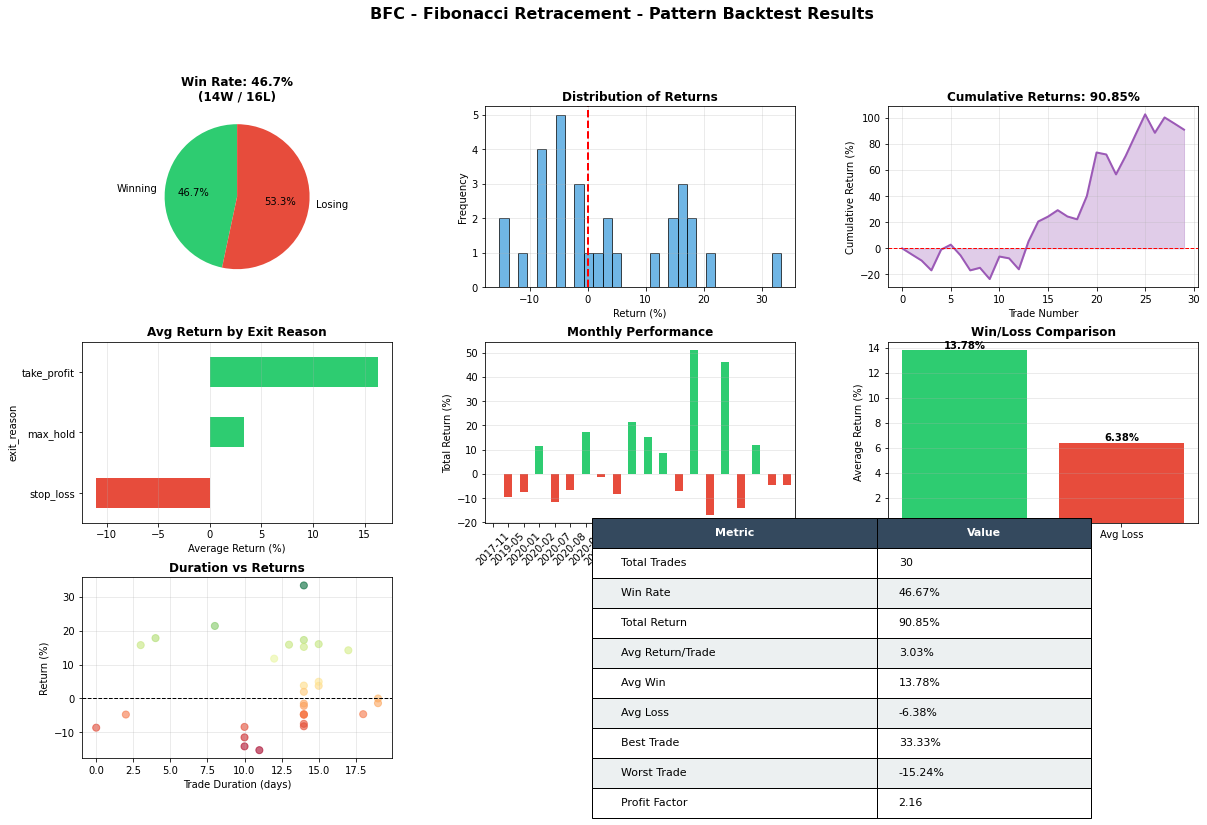


INTERACTIVE PRICE CHART WITH PATTERN SIGNALS
Installing plotly for interactive charts...



💡 Tip: Use the plotly controls to:
   - Zoom in/out to inspect specific patterns
   - Hover over markers to see entry/exit details
   - Click legend items to show/hide traces
   - Double-click to reset the view

FIRST 10 FIBONACCI PATTERN TRADES


,entry_date,exit_date,entry_price,exit_price,pnl_pct,exit_reason
0,2017-11-21,2017-12-10,133.0,133.00,0.000000,max_hold
1,2019-05-20,2019-06-03,106.0,101.00,-4.716981,max_hold
2,2019-05-29,2019-06-16,108.0,103.00,-4.629630,max_hold
3,2020-01-21,2020-02-04,107.0,99.00,-7.476636,max_hold
4,2020-02-05,2020-02-18,100.0,115.86,15.860000,take_profit
5,2020-02-16,2020-03-01,105.0,109.00,3.809524,max_hold
6,2020-02-25,2020-03-10,110.0,100.98,-8.200000,stop_loss
7,2020-07-27,2020-08-06,104.0,92.07,-11.471154,stop_loss
8,2020-08-17,2020-08-31,102.0,104.00,1.960784,max_hold
9,2020-08-31,2020-08-31,104.0,95.04,-8.615385,stop_loss



FIBONACCI LEVEL DETAILS FOR FIRST 5 TRADES

Trade 1:
  Entry Date: 2017-11-21 00:00:00
  Swing High: 138.00
  Swing Low: 128.00
  Fib Level Touched: 38.2%
  Fib Price: 134.18
  Entry Price: 133.00
  P&L: 0.00%

Trade 2:
  Entry Date: 2019-05-20 00:00:00
  Swing High: 100.00
  Swing Low: 95.00
  Fib Level Touched: 38.2%
  Fib Price: 98.09
  Entry Price: 106.00
  P&L: -4.72%

Trade 3:
  Entry Date: 2019-05-29 00:00:00
  Swing High: 116.00
  Swing Low: 97.00
  Fib Level Touched: 50.0%
  Fib Price: 106.50
  Entry Price: 108.00
  P&L: -4.63%

Trade 4:
  Entry Date: 2020-01-21 00:00:00
  Swing High: 109.00
  Swing Low: 89.00
  Fib Level Touched: 38.2%
  Fib Price: 101.36
  Entry Price: 107.00
  P&L: -7.48%

Trade 5:
  Entry Date: 2020-02-05 00:00:00
  Swing High: 102.00
  Swing Low: 93.00
  Fib Level Touched: 38.2%
  Fib Price: 98.56
  Entry Price: 100.00
  P&L: 15.86%


In [9]:

def detect_fibonacci_retracement_pattern(daily_df: pd.DataFrame, idx: int) -> Dict:
    """
    Detect Fibonacci retracement pattern:
    1. Identify a significant swing (uptrend or downtrend)
    2. Calculate Fibonacci retracement levels (23.6%, 38.2%, 50%, 61.8%, 78.6%)
    3. Detect price retracement to key Fibonacci level
    4. Look for bullish reversal signal at Fibonacci support
    
    Args:
        daily_df: Daily timeframe data
        idx: Current index in daily_df
        
    Returns:
        Dict with 'signal': bool, 'entry_price': float, 'stop_loss': float, 
        'take_profit': float, 'details': dict
    """
    
    # Need at least 30 candles to identify proper swing
    if idx < 30:
        return {'signal': False}
    
    # Look back to find significant swing
    lookback = 20
    swing_data = daily_df.iloc[max(0, idx - lookback):idx]
    
    # Find swing high and swing low in the lookback period
    swing_high_idx = swing_data['high'].idxmax()
    swing_low_idx = swing_data['low'].idxmin()
    
    swing_high = swing_data.loc[swing_high_idx, 'high']
    swing_low = swing_data.loc[swing_low_idx, 'low']
    
    # Calculate swing magnitude
    swing_magnitude = swing_high - swing_low
    
    # Require minimum 5% swing to be significant
    if swing_magnitude / swing_low < 0.05:
        return {'signal': False}
    
    # Determine if we had an uptrend (low before high) or downtrend
    # For bullish signal, we want uptrend followed by retracement
    if swing_low_idx > swing_high_idx:
        # Downtrend - not suitable for bullish entry
        return {'signal': False}
    
    # Calculate Fibonacci retracement levels
    fib_levels = {
        '0.0': swing_high,
        '0.236': swing_high - (swing_magnitude * 0.236),
        '0.382': swing_high - (swing_magnitude * 0.382),
        '0.500': swing_high - (swing_magnitude * 0.500),
        '0.618': swing_high - (swing_magnitude * 0.618),
        '0.786': swing_high - (swing_magnitude * 0.786),
        '1.0': swing_low
    }
    
    # Get current candle
    current_candle = daily_df.iloc[idx]
    current_price = current_candle['close']
    current_low = current_candle['low']
    
    # Check if price has retraced to a key Fibonacci level (38.2%, 50%, or 61.8%)
    key_fib_levels = [0.382, 0.500, 0.618]
    touched_fib_level = None
    fib_level_value = None
    
    # Allow 1% tolerance for hitting Fibonacci level
    tolerance = swing_magnitude * 0.01
    
    for fib in key_fib_levels:
        fib_price = fib_levels[f'{fib:.3f}']
        if abs(current_low - fib_price) <= tolerance or (current_low <= fib_price <= current_candle['high']):
            touched_fib_level = fib
            fib_level_value = fib_price
            break
    
    if touched_fib_level is None:
        return {'signal': False}
    
    # Look for bullish reversal signal (bullish candle at Fibonacci level)
    is_bullish = current_candle['close'] > current_candle['open']
    
    # Additional confirmation: check if previous candle was bearish (showing selling pressure before reversal)
    if idx > 0:
        prev_candle = daily_df.iloc[idx - 1]
        prev_was_bearish = prev_candle['close'] < prev_candle['open']
        
        # Stronger signal if we have bearish-to-bullish reversal
        if not (is_bullish and prev_was_bearish):
            return {'signal': False}
    else:
        if not is_bullish:
            return {'signal': False}
    
    # Check volume confirmation (if available)
    if 'Traded_Shares' in current_candle.index:
        avg_volume = daily_df.iloc[max(0, idx-10):idx]['Traded_Shares'].mean()
        if current_candle['Traded_Shares'] < avg_volume * 0.8:
            # Low volume - weak signal
            return {'signal': False}
    
    # Define entry, stop loss, and take profit
    entry_price = current_candle['close']
    
    # Stop loss: below the Fibonacci level or swing low
    stop_loss = min(fib_level_value * 0.98, swing_low * 0.99)
    
    # Take profit: target the swing high or next Fibonacci extension
    # Use risk-reward ratio of 1:2
    risk = entry_price - stop_loss
    take_profit = entry_price + (risk * 2)
    
    # Alternative: target swing high if it gives better R:R
    potential_tp_swing_high = swing_high * 0.99  # Slightly below swing high
    if potential_tp_swing_high > take_profit:
        take_profit = potential_tp_swing_high
    
    return {
        'signal': True,
        'entry_price': entry_price,
        'stop_loss': stop_loss,
        'take_profit': take_profit,
        'details': {
            'swing_high': swing_high,
            'swing_low': swing_low,
            'fib_level_touched': touched_fib_level,
            'fib_level_price': fib_level_value,
            'fib_0.236': fib_levels['0.236'],
            'fib_0.382': fib_levels['0.382'],
            'fib_0.500': fib_levels['0.500'],
            'fib_0.618': fib_levels['0.618'],
            'entry_date': current_candle['date']
        }
    }


# Example: Backtest Fibonacci Retracement Pattern
symbol_fib = "BFC"

# Load stock data (reuse the data if already loaded)
if 'daily_df' not in locals() or daily_df.empty:
    daily_df = load_stock_data_from_hdfs(
        spark, 
        hdfs_base_path, 
        symbol_fib, 
        start_year=2012, 
        end_year=2022
    )

# Run backtest with Fibonacci pattern
print(f"\n{'='*80}")
print(f"BACKTESTING FIBONACCI RETRACEMENT PATTERN FOR {symbol_fib}")
print(f"{'='*80}")

trades_fib = backtest_pattern(
    daily_df, 
    detect_fibonacci_retracement_pattern,  # Use Fibonacci pattern function
    max_hold_days=30
)

# Visualize results
if trades_fib:
    results_fib_df = visualize_backtest_results(trades_fib, f"{symbol_fib} - Fibonacci Retracement", daily_df)
    
    # Display detailed results
    print("\n" + "="*100)
    print("FIRST 10 FIBONACCI PATTERN TRADES")
    print("="*100)
    display(results_fib_df[['entry_date', 'exit_date', 'entry_price', 'exit_price', 
                            'pnl_pct', 'exit_reason']].head(10))
    
    # Show pattern-specific details
    print("\n" + "="*100)
    print("FIBONACCI LEVEL DETAILS FOR FIRST 5 TRADES")
    print("="*100)
    for i, trade in enumerate(trades_fib[:5]):
        details = trade['details']
        print(f"\nTrade {i+1}:")
        print(f"  Entry Date: {trade['entry_date']}")
        print(f"  Swing High: {details.get('swing_high', 'N/A'):.2f}")
        print(f"  Swing Low: {details.get('swing_low', 'N/A'):.2f}")
        print(f"  Fib Level Touched: {details.get('fib_level_touched', 'N/A'):.1%}")
        print(f"  Fib Price: {details.get('fib_level_price', 'N/A'):.2f}")
        print(f"  Entry Price: {trade['entry_price']:.2f}")
        print(f"  P&L: {trade['pnl_pct']:.2f}%")
    
    # Export to CSV if needed
    # results_fib_df.to_csv(f'{symbol_fib}_fibonacci_backtest_results.csv', index=False)
else:
    print("No trades found matching the Fibonacci retracement pattern criteria.")
    


## LSTM

In [10]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import pickle
import os
from typing import Tuple, List

# ============================================================================
# LSTM MODEL ARCHITECTURE
# ============================================================================

class StockLSTM(nn.Module):
    """
    LSTM model for stock price prediction.
    """
    def __init__(self, input_size: int, hidden_size: int = 64, num_layers: int = 2, dropout: float = 0.2):
        super(StockLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0,
            batch_first=True
        )
        
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        # x shape: (batch_size, seq_length, input_size)
        lstm_out, _ = self.lstm(x)
        # Take the last output
        out = lstm_out[:, -1, :]
        out = self.dropout(out)
        out = self.fc(out)
        return out


# ============================================================================
# DATASET CLASS
# ============================================================================

class StockSequenceDataset(Dataset):
    """
    Dataset for creating sequences from stock data.
    """
    def __init__(self, data: np.ndarray, sequence_length: int = 20, target_col: int = 0):
        """
        Args:
            data: Numpy array of shape (n_samples, n_features)
            sequence_length: Number of time steps in each sequence
            target_col: Column index to predict (typically close price)
        """
        self.data = data
        self.sequence_length = sequence_length
        self.target_col = target_col
        
    def __len__(self):
        return len(self.data) - self.sequence_length
    
    def __getitem__(self, idx):
        # Get sequence
        X = self.data[idx:idx + self.sequence_length]
        # Get target (next day's close price)
        y = self.data[idx + self.sequence_length, self.target_col]
        
        return torch.FloatTensor(X), torch.FloatTensor([y])


# ============================================================================
# TRAINING FUNCTION
# ============================================================================

def train_lstm_model(
    stock_symbol: str,
    spark,
    hdfs_base_path: str,
    start_year: int = 2012,
    end_year: int = 2020,
    sequence_length: int = 20,
    hidden_size: int = 64,
    num_layers: int = 2,
    dropout: float = 0.2,
    batch_size: int = 32,
    epochs: int = 50,
    learning_rate: float = 0.001,
    val_split: float = 0.2,
    device: str = None
) -> Tuple[StockLSTM, MinMaxScaler, dict]:
    """
    Train LSTM model for stock price prediction with chronological train/val split.
    
    Args:
        stock_symbol: Stock symbol to train on
        spark: SparkSession
        hdfs_base_path: Base HDFS path for data
        start_year: Training data start year
        end_year: Training data end year
        sequence_length: Number of time steps in sequences
        hidden_size: LSTM hidden layer size
        num_layers: Number of LSTM layers
        dropout: Dropout rate
        batch_size: Training batch size
        epochs: Number of training epochs
        learning_rate: Learning rate for optimizer
        val_split: Fraction of data for validation (from the end)
        device: Device to train on ('cuda' or 'cpu')
        
    Returns:
        Tuple of (trained_model, scaler, training_history)
    """
    
    # Set device
    if device is None:
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"Using device: {device}")
    
    # Load data
    print(f"\n{'='*80}")
    print(f"TRAINING LSTM FOR {stock_symbol}")
    print(f"{'='*80}")
    
    df = load_stock_data_from_hdfs(spark, hdfs_base_path, stock_symbol, start_year, end_year)
    
    if df.empty:
        raise ValueError(f"No data found for {stock_symbol}")
    
    # Prepare features
    feature_cols = ['open', 'high', 'low', 'close']
    data = df[feature_cols].values
    dates = df['date'].values
    
    print(f"\nData shape: {data.shape}")
    print(f"Date range: {df['date'].min()} to {df['date'].max()}")
    
    # CHRONOLOGICAL SPLIT: Latest data for validation
    train_size = int(len(data) * (1 - val_split))
    train_data = data[:train_size]
    val_data = data[train_size:]
    train_dates = dates[:train_size]
    val_dates = dates[train_size:]
    
    print(f"\nTraining samples: {len(train_data)} (up to {train_dates[-1]})")
    print(f"Validation samples: {len(val_data)} (from {val_dates[0]} to {val_dates[-1]})")
    
    # Normalize data
    scaler = MinMaxScaler()
    train_data_scaled = scaler.fit_transform(train_data)
    val_data_scaled = scaler.transform(val_data)
    
    # Create datasets
    train_dataset = StockSequenceDataset(train_data_scaled, sequence_length, target_col=3)
    val_dataset = StockSequenceDataset(val_data_scaled, sequence_length, target_col=3)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    print(f"\nSequence length: {sequence_length}")
    print(f"Batch size: {batch_size}")
    print(f"Training batches: {len(train_loader)}")
    print(f"Validation batches: {len(val_loader)}")
    
    # Initialize model
    model = StockLSTM(
        input_size=len(feature_cols),
        hidden_size=hidden_size,
        num_layers=num_layers,
        dropout=dropout
    ).to(device)
    
    print(f"\nModel architecture:")
    print(f"  Input size: {len(feature_cols)}")
    print(f"  Hidden size: {hidden_size}")
    print(f"  Num layers: {num_layers}")
    print(f"  Dropout: {dropout}")
    
    # Loss and optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)
    
    # Training history
    history = {
        'train_loss': [],
        'val_loss': [],
        'best_val_loss': float('inf'),
        'best_epoch': 0
    }
    
    # Training loop
    print(f"\n{'='*80}")
    print("TRAINING")
    print(f"{'='*80}")
    
    best_model_state = None
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                val_loss += loss.item()
        
        val_loss /= len(val_loader)
        
        # Update history
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        
        # Save best model
        if val_loss < history['best_val_loss']:
            history['best_val_loss'] = val_loss
            history['best_epoch'] = epoch
            best_model_state = model.state_dict().copy()
        
        # Update learning rate
        scheduler.step(val_loss)
        
        # Print progress
        if (epoch + 1) % 5 == 0 or epoch == 0:
            print(f"Epoch [{epoch+1}/{epochs}] - Train Loss: {train_loss:.6f} - Val Loss: {val_loss:.6f}")
    
    # Load best model
    model.load_state_dict(best_model_state)
    
    # Get validation predictions for visualization
    model.eval()
    val_predictions = []
    val_actuals = []
    
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)
            val_predictions.extend(outputs.cpu().numpy().flatten())
            val_actuals.extend(batch_y.cpu().numpy().flatten())
    
    val_predictions = np.array(val_predictions)
    val_actuals = np.array(val_actuals)
    
    # Calculate metrics
    val_mae = np.mean(np.abs(val_predictions - val_actuals))
    val_rmse = np.sqrt(np.mean((val_predictions - val_actuals)**2))
    val_mape = np.mean(np.abs((val_actuals - val_predictions) / val_actuals)) * 100
    
    print(f"\nValidation MAE: {val_mae:.6f}")
    print(f"Validation RMSE: {val_rmse:.6f}")
    print(f"Validation MAPE: {val_mape:.2f}%")
    
    # Store validation results in history
    history['val_predictions'] = val_predictions
    history['val_actuals'] = val_actuals
    history['val_dates'] = val_dates[sequence_length:]
    history['val_mae'] = val_mae
    history['val_rmse'] = val_rmse
    history['val_mape'] = val_mape
    
    print(f"\n{'='*80}")
    print(f"Training completed!")
    print(f"Best validation loss: {history['best_val_loss']:.6f} at epoch {history['best_epoch']+1}")
    print(f"{'='*80}")
    
    return model, scaler, history


# ============================================================================
# MODEL PERSISTENCE (HDFS)
# ============================================================================

def save_model_to_hdfs(
    model: StockLSTM,
    scaler: MinMaxScaler,
    history: dict,
    stock_symbol: str,
    hdfs_base_path: str,
    model_config: dict,
    spark=None
):
    """
    Save trained model, scaler, and metadata to HDFS using Spark.
    """
    print(f"\nSaving model for {stock_symbol} to HDFS...")
    
    # Create local temp directory
    temp_dir = f"/tmp/lstm_models/{stock_symbol}"
    os.makedirs(temp_dir, exist_ok=True)
    
    # Save model state
    model_path = f"{temp_dir}/model.pth"
    torch.save(model.state_dict(), model_path)
    
    # Save scaler
    scaler_path = f"{temp_dir}/scaler.pkl"
    with open(scaler_path, 'wb') as f:
        pickle.dump(scaler, f)
    
    # Save metadata
    metadata = {
        'stock_symbol': stock_symbol,
        'model_config': model_config,
        'history': history
    }
    metadata_path = f"{temp_dir}/metadata.pkl"
    with open(metadata_path, 'wb') as f:
        pickle.dump(metadata, f)
    
    # Upload to HDFS using Spark
    hdfs_model_path = f"hdfs://namenode:9000{hdfs_base_path}/models/lstm/{stock_symbol}"
    
    try:
        # Get Spark context
        if spark is None:
            from pyspark.sql import SparkSession
            spark = SparkSession.builder.getOrCreate()
        
        sc = spark.sparkContext
        
        # Upload each file
        for filename, local_path in [('model.pth', model_path), 
                                       ('scaler.pkl', scaler_path), 
                                       ('metadata.pkl', metadata_path)]:
            # Read file as bytes
            with open(local_path, 'rb') as f:
                file_bytes = f.read()
            
            # Create RDD and save to HDFS
            hdfs_file_path = f"{hdfs_model_path}/{filename}"
            rdd = sc.parallelize([file_bytes], 1)
            rdd.saveAsPickleFile(hdfs_file_path)
            
        print(f"✓ Model saved to HDFS: {hdfs_model_path}")
        
    except Exception as e:
        print(f"Error saving to HDFS: {e}")
        print("Attempting alternative method using local filesystem...")
        
        # Fallback: save to local directory
        local_hdfs_path = f"./models/lstm/{stock_symbol}"
        os.makedirs(local_hdfs_path, exist_ok=True)
        
        import shutil
        shutil.copy(model_path, f"{local_hdfs_path}/model.pth")
        shutil.copy(scaler_path, f"{local_hdfs_path}/scaler.pkl")
        shutil.copy(metadata_path, f"{local_hdfs_path}/metadata.pkl")
        
        print(f"✓ Model saved to local path: {local_hdfs_path}")
        print(f"  (Use this path for loading if HDFS upload failed)")
    
    finally:
        # Cleanup temp directory
        import shutil
        shutil.rmtree(temp_dir, ignore_errors=True)


def load_model_from_hdfs(
    stock_symbol: str,
    hdfs_base_path: str,
    device: str = None,
    spark=None
) -> Tuple[StockLSTM, MinMaxScaler, dict]:
    """
    Load trained model, scaler, and metadata from HDFS using Spark.
    """
    print(f"\nLoading model for {stock_symbol} from HDFS...")
    
    if device is None:
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    # Create local temp directory
    temp_dir = f"/tmp/lstm_models/{stock_symbol}"
    os.makedirs(temp_dir, exist_ok=True)
    
    try:
        # Get Spark context
        if spark is None:
            from pyspark.sql import SparkSession
            spark = SparkSession.builder.getOrCreate()
        
        sc = spark.sparkContext
        
        # Download from HDFS using Spark
        hdfs_model_path = f"hdfs://namenode:9000{hdfs_base_path}/models/lstm/{stock_symbol}"
        
        # Load each file
        for filename, local_path in [('model.pth', f"{temp_dir}/model.pth"),
                                       ('scaler.pkl', f"{temp_dir}/scaler.pkl"),
                                       ('metadata.pkl', f"{temp_dir}/metadata.pkl")]:
            hdfs_file_path = f"{hdfs_model_path}/{filename}"
            
            # Load from HDFS
            rdd = sc.pickleFile(hdfs_file_path)
            file_bytes = rdd.collect()[0]
            
            # Write to local temp
            with open(local_path, 'wb') as f:
                f.write(file_bytes)
        
        print(f"✓ Files downloaded from HDFS")
        
    except Exception as e:
        print(f"Error loading from HDFS: {e}")
        print("Attempting to load from local filesystem...")
        
        # Fallback: load from local directory
        local_model_path = f"./models/lstm/{stock_symbol}"
        
        import shutil
        shutil.copy(f"{local_model_path}/model.pth", f"{temp_dir}/model.pth")
        shutil.copy(f"{local_model_path}/scaler.pkl", f"{temp_dir}/scaler.pkl")
        shutil.copy(f"{local_model_path}/metadata.pkl", f"{temp_dir}/metadata.pkl")
        
        print(f"✓ Files loaded from local path: {local_model_path}")
    
    # Load metadata
    with open(f"{temp_dir}/metadata.pkl", 'rb') as f:
        metadata = pickle.load(f)
    
    # Load scaler
    with open(f"{temp_dir}/scaler.pkl", 'rb') as f:
        scaler = pickle.load(f)
    
    # Recreate model
    config = metadata['model_config']
    model = StockLSTM(
        input_size=config['input_size'],
        hidden_size=config['hidden_size'],
        num_layers=config['num_layers'],
        dropout=config['dropout']
    ).to(device)
    
    # Load model state
    model.load_state_dict(torch.load(f"{temp_dir}/model.pth", map_location=device))
    model.eval()
    
    print(f"✓ Model loaded successfully")
    
    # Cleanup
    import shutil
    shutil.rmtree(temp_dir, ignore_errors=True)
    
    return model, scaler, metadata


# ============================================================================
# INFERENCE FUNCTION
# ============================================================================

def predict_next_day(
    model: StockLSTM,
    scaler: MinMaxScaler,
    recent_data: np.ndarray,
    sequence_length: int = 20,
    device: str = None
) -> float:
    """
    Predict next day's closing price.
    
    Args:
        model: Trained LSTM model
        scaler: Fitted MinMaxScaler
        recent_data: Recent OHLC data (last sequence_length days)
        sequence_length: Length of input sequence
        device: Device to run inference on
        
    Returns:
        Predicted close price
    """
    if device is None:
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    model.eval()
    
    # Ensure we have enough data
    if len(recent_data) < sequence_length:
        raise ValueError(f"Need at least {sequence_length} days of data")
    
    # Take last sequence_length days
    sequence = recent_data[-sequence_length:]
    
    # Scale data
    sequence_scaled = scaler.transform(sequence)
    
    # Convert to tensor
    X = torch.FloatTensor(sequence_scaled).unsqueeze(0).to(device)
    
    # Predict
    with torch.no_grad():
        pred_scaled = model(X).cpu().numpy()[0, 0]
    
    # Inverse transform to get actual price
    dummy = np.zeros((1, 4))
    dummy[0, 3] = pred_scaled
    pred_price = scaler.inverse_transform(dummy)[0, 3]
    
    return pred_price


print("✓ LSTM model architecture and functions loaded successfully")

✓ LSTM model architecture and functions loaded successfully


## Example 1: Train LSTM Model and Save to HDFS

### ✅ HDFS Integration Fixed

The save/load functions now use **Spark's filesystem API** instead of shell commands:

- **`save_model_to_hdfs`**: Uses `sc.parallelize()` and `saveAsPickleFile()` to write to HDFS
- **`load_model_from_hdfs`**: Uses `sc.pickleFile()` to read from HDFS
- **Fallback mechanism**: If HDFS access fails, saves/loads from local `./models/` directory
- **No subprocess calls**: All operations use native Python/Spark APIs

This works seamlessly with your existing Spark setup!

Using device: cpu

TRAINING LSTM FOR BFC
Loading data for BFC...


  Loaded year 2012: 8 rows
  Year 2013 not found or error: Path does not exist: hdfs://namenode:9000/user/spark/NEPSE_data_parquet/stock_symbol=BFC/year=2013
  Year 2014 not found or error: Path does not exist: hdfs://namenode:9000/user/spark/NEPSE_data_parquet/stock_symbol=BFC/year=2014
  Year 2015 not found or error: Path does not exist: hdfs://namenode:9000/user/spark/NEPSE_data_parquet/stock_symbol=BFC/year=2015
  Year 2016 not found or error: Path does not exist: hdfs://namenode:9000/user/spark/NEPSE_data_parquet/stock_symbol=BFC/year=2016
  Loaded year 2017: 292 rows
  Loaded year 2018: 444 rows
  Loaded year 2019: 716 rows
  Loaded year 2020: 736 rows
  Loaded year 2021: 956 rows
  Loaded year 2022: 508 rows
  Year 2023 not found or error: Path does not exist: hdfs://namenode:9000/user/spark/NEPSE_data_parquet/stock_symbol=BFC/year=2023
  Year 2024 not found or error: Path does not exist: hdfs://namenode:9000/user/spark/NEPSE_data_parquet/stock_symbol=BFC/year=2024
  Year 2025 n

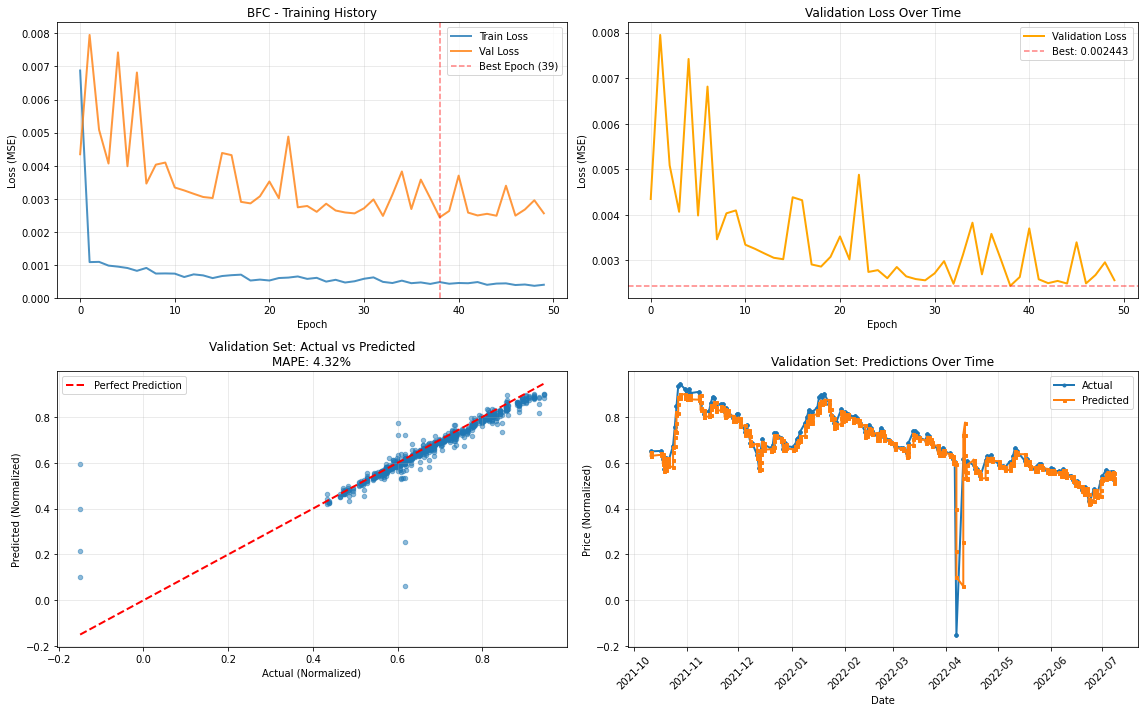


VALIDATION SET METRICS
MAE (Mean Absolute Error): 0.020208
RMSE (Root Mean Squared Error): 0.051456
MAPE (Mean Absolute Percentage Error): 4.32%

✓ Model trained and ready to save to HDFS for BFC


In [11]:
# Train LSTM model for a specific stock
stock_symbol_lstm = "BFC"

# Model configuration
model_config = {
    'input_size': 4,  # OHLC
    'hidden_size': 64,
    'num_layers': 2,
    'dropout': 0.2,
    'sequence_length': 20,
    'batch_size': 32,
    'epochs': 50,
    'learning_rate': 0.001
}

# Train model
model, scaler, history = train_lstm_model(
    stock_symbol=stock_symbol_lstm,
    spark=spark,
    hdfs_base_path=hdfs_base_path,
    start_year=2012,
    end_year=2025,
    sequence_length=model_config['sequence_length'],
    hidden_size=model_config['hidden_size'],
    num_layers=model_config['num_layers'],
    dropout=model_config['dropout'],
    batch_size=model_config['batch_size'],
    epochs=model_config['epochs'],
    learning_rate=model_config['learning_rate']
)

# Save to HDFS
save_model_to_hdfs(
    model=model,
    scaler=scaler,
    history=history,
    stock_symbol=stock_symbol_lstm,
    hdfs_base_path=hdfs_base_path,
    model_config=model_config,
    spark=spark
)

# Plot training history
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# 1. Training and Validation Loss
ax = axes[0, 0]
ax.plot(history['train_loss'], label='Train Loss', linewidth=2, alpha=0.8)
ax.plot(history['val_loss'], label='Val Loss', linewidth=2, alpha=0.8)
ax.axvline(history['best_epoch'], color='red', linestyle='--', alpha=0.5, 
           label=f"Best Epoch ({history['best_epoch']+1})")
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss (MSE)')
ax.set_title(f'{stock_symbol_lstm} - Training History')
ax.legend()
ax.grid(True, alpha=0.3)

# 2. Validation Loss Only
ax = axes[0, 1]
ax.plot(history['val_loss'], label='Validation Loss', linewidth=2, color='orange')
ax.axhline(history['best_val_loss'], color='red', linestyle='--', alpha=0.5,
           label=f"Best: {history['best_val_loss']:.6f}")
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss (MSE)')
ax.set_title('Validation Loss Over Time')
ax.legend()
ax.grid(True, alpha=0.3)

# 3. Validation Predictions vs Actuals (Scatter)
if 'val_predictions' in history:
    ax = axes[1, 0]
    ax.scatter(history['val_actuals'], history['val_predictions'], alpha=0.5, s=20)
    
    # Perfect prediction line
    min_val = min(history['val_actuals'].min(), history['val_predictions'].min())
    max_val = max(history['val_actuals'].max(), history['val_predictions'].max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')
    
    ax.set_xlabel('Actual (Normalized)')
    ax.set_ylabel('Predicted (Normalized)')
    ax.set_title(f'Validation Set: Actual vs Predicted\nMAPE: {history["val_mape"]:.2f}%')
    ax.legend()
    ax.grid(True, alpha=0.3)

# 4. Validation Predictions Time Series
if 'val_predictions' in history and 'val_dates' in history:
    ax = axes[1, 1]
    val_dates = history['val_dates']
    
    # Plot actual vs predicted over time
    ax.plot(val_dates, history['val_actuals'], label='Actual', linewidth=2, marker='o', markersize=3)
    ax.plot(val_dates, history['val_predictions'], label='Predicted', linewidth=2, marker='s', markersize=3)
    
    ax.set_xlabel('Date')
    ax.set_ylabel('Price (Normalized)')
    ax.set_title('Validation Set: Predictions Over Time')
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

print(f"\n{'='*80}")
print("VALIDATION SET METRICS")
print(f"{'='*80}")
if 'val_mae' in history:
    print(f"MAE (Mean Absolute Error): {history['val_mae']:.6f}")
    print(f"RMSE (Root Mean Squared Error): {history['val_rmse']:.6f}")
    print(f"MAPE (Mean Absolute Percentage Error): {history['val_mape']:.2f}%")
print(f"{'='*80}")

print(f"\n✓ Model trained and ready to save to HDFS for {stock_symbol_lstm}")

## Example 2: Load Model and Make Predictions


Loading model for BFC from HDFS...
✓ Files downloaded from HDFS
✓ Model loaded successfully

Model Configuration:
  Stock: BFC
  Hidden Size: 64
  Num Layers: 2
  Sequence Length: 20
  Best Val Loss: 0.004545
Loading data for BFC...
  Loaded year 2022: 381 rows
Total rows loaded: 381
After cleaning: 381 rows
Date range: 2022-01-02 00:00:00 to 2022-07-08 00:00:00

RECENT PREDICTIONS

Date: 2022-01-10
  Actual: $508.00
  Predicted: $506.21
  Error: -0.35%

Date: 2022-01-11
  Actual: $525.00
  Predicted: $511.16
  Error: -2.64%

Date: 2022-01-11
  Actual: $525.00
  Predicted: $516.12
  Error: -1.69%

Date: 2022-01-11
  Actual: $525.00
  Predicted: $519.97
  Error: -0.96%

Date: 2022-01-12
  Actual: $504.00
  Predicted: $522.51
  Error: +3.67%

Date: 2022-01-12
  Actual: $504.00
  Predicted: $523.98
  Error: +3.96%

Date: 2022-01-12
  Actual: $504.00
  Predicted: $524.55
  Error: +4.08%

Date: 2022-01-13
  Actual: $520.00
  Predicted: $524.47
  Error: +0.86%

Date: 2022-01-13
  Actual: $5

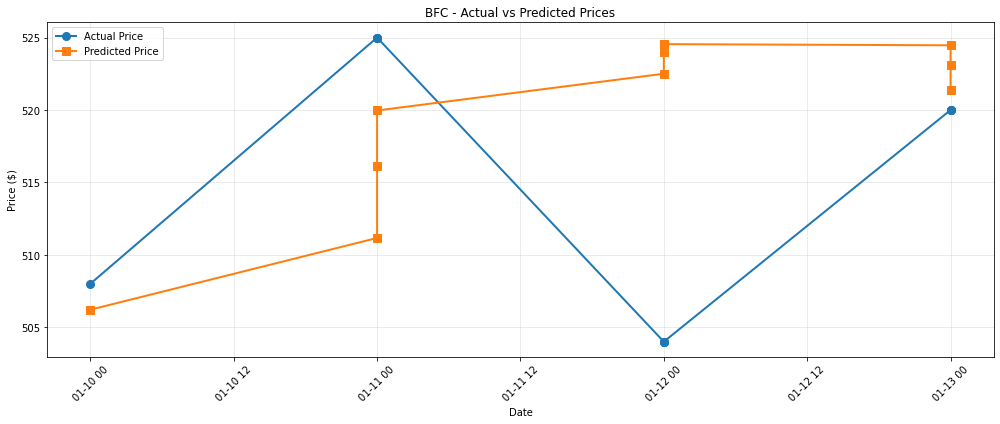

In [12]:
# Load model from HDFS
loaded_model, loaded_scaler, loaded_metadata = load_model_from_hdfs(
    stock_symbol=stock_symbol_lstm,
    hdfs_base_path=hdfs_base_path,
    spark=spark
)

print(f"\nModel Configuration:")
print(f"  Stock: {loaded_metadata['stock_symbol']}")
print(f"  Hidden Size: {loaded_metadata['model_config']['hidden_size']}")
print(f"  Num Layers: {loaded_metadata['model_config']['num_layers']}")
print(f"  Sequence Length: {loaded_metadata['model_config']['sequence_length']}")
print(f"  Best Val Loss: {loaded_metadata['history']['best_val_loss']:.6f}")

# Load recent data for inference
df_recent = load_stock_data_from_hdfs(
    spark=spark,
    hdfs_base_path=hdfs_base_path,
    stock_symbol=stock_symbol_lstm,
    start_year=2022,
    end_year=2022
)

# Make predictions for the last 10 days
print(f"\n{'='*80}")
print("RECENT PREDICTIONS")
print(f"{'='*80}")

feature_cols = ['open', 'high', 'low', 'close']
sequence_length = loaded_metadata['model_config']['sequence_length']

predictions = []

for i in range(sequence_length, min(sequence_length + 10, len(df_recent))):
    # Get historical data
    hist_data = df_recent.iloc[i - sequence_length:i][feature_cols].values
    
    # Predict
    predicted_price = predict_next_day(
        model=loaded_model,
        scaler=loaded_scaler,
        recent_data=hist_data,
        sequence_length=sequence_length
    )
    
    actual_price = df_recent.iloc[i]['close']
    date = df_recent.iloc[i]['date']
    error = ((predicted_price - actual_price) / actual_price) * 100
    
    predictions.append({
        'date': date,
        'actual': actual_price,
        'predicted': predicted_price,
        'error_pct': error
    })
    
    print(f"\nDate: {date.strftime('%Y-%m-%d')}")
    print(f"  Actual: ${actual_price:.2f}")
    print(f"  Predicted: ${predicted_price:.2f}")
    print(f"  Error: {error:+.2f}%")

# Calculate average error
df_pred = pd.DataFrame(predictions)
avg_error = df_pred['error_pct'].abs().mean()
print(f"\n{'='*80}")
print(f"Average Absolute Error: {avg_error:.2f}%")
print(f"{'='*80}")

# Visualize predictions
plt.figure(figsize=(14, 6))

plt.plot(df_pred['date'], df_pred['actual'], marker='o', label='Actual Price', linewidth=2, markersize=8)
plt.plot(df_pred['date'], df_pred['predicted'], marker='s', label='Predicted Price', linewidth=2, markersize=8)

plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.title(f'{stock_symbol_lstm} - Actual vs Predicted Prices')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Example 3: Backtest LSTM Trading Strategy

In [12]:
# ...existing code...

def backtest_lstm_model(
    stock_symbol: str,
    spark,
    hdfs_base_path: str,
    test_start_year: int,
    test_end_year: int,
    sequence_length: int = 20,
    initial_capital: float = 100000.0,
    position_size: float = 0.95,
    transaction_cost: float = 0.001,
    device: str = None,
):
    """
    Simple LSTM one-day prediction trading backtest:
    - Load trained model via load_model_from_hdfs
    - For each day in test range, predict next-day close using last `sequence_length` days
    - If predicted > current close => go long next day (enter at next day's open if present, exit at that day's close)
    - Position sizing: fraction of available capital
    - Returns dict {trades, portfolio_values}
    """
    # Load model & scaler
    model, scaler, metadata = load_model_from_hdfs(stock_symbol, hdfs_base_path, device=device, spark=spark)

    # Load test data
    df_test = load_stock_data_from_hdfs(spark, hdfs_base_path, stock_symbol, start_year=test_start_year, end_year=test_end_year)
    if df_test.empty or len(df_test) < sequence_length + 2:
        raise ValueError("Not enough test data for backtest")

    feature_cols = ['open', 'high', 'low', 'close']
    data = df_test[feature_cols].values
    dates = pd.to_datetime(df_test['date']).reset_index(drop=True)

    capital = initial_capital
    cash = capital
    trades = []
    portfolio_values = []

    holding = False
    held_shares = 0
    entry_price = 0.0
    entry_date = None

    # iterate through days where we can form a sequence and have next-day data
    for i in range(sequence_length, len(data) - 1):
        # current day's close
        current_close = data[i, 3]
        seq = data[i - sequence_length + 1:i + 1]  # last sequence_length rows ending at i
        seq_scaled = scaler.transform(seq)
        X = torch.FloatTensor(seq_scaled).unsqueeze(0)
        X = X.to('cpu')
        with torch.no_grad():
            pred_scaled = model(X).cpu().numpy()[0, 0]
        # inverse transform the predicted close
        dummy = np.zeros((1, 4))
        dummy[0, 3] = pred_scaled
        pred_price = scaler.inverse_transform(dummy)[0, 3]

        # decision: go long if predicted > current_close
        if (pred_price > current_close) and (not holding):
            # enter next day at next day's open if available else next day's close
            next_open = data[i + 1, 0] if not np.isnan(data[i + 1, 0]) else data[i + 1, 3]
            if next_open <= 0:
                continue
            invest_amount = cash * position_size
            shares = int(invest_amount // next_open)
            if shares <= 0:
                continue
            buy_value = shares * next_open
            buy_fee = buy_value * transaction_cost
            cash -= (buy_value + buy_fee)
            holding = True
            held_shares = shares
            entry_price = next_open
            entry_date = dates[i + 1]
            trades.append({
                'action': 'BUY',
                'date': entry_date,
                'price': entry_price,
                'shares': shares,
                'cash_after': cash
            })

        # exit rule: exit same day (one-day hold) at next day's close if holding
        if holding:
            exit_price = data[i + 1, 3]
            sell_value = held_shares * exit_price
            sell_fee = sell_value * transaction_cost
            cash += (sell_value - sell_fee)
            exit_date = dates[i + 1]
            pnl = (exit_price - entry_price) * held_shares - (buy_fee + sell_fee if 'buy_fee' in locals() else sell_fee)
            trades.append({
                'action': 'SELL',
                'date': exit_date,
                'price': exit_price,
                'shares': held_shares,
                'cash_after': cash,
                'pnl': pnl
            })
            holding = False
            held_shares = 0
            entry_price = 0.0
            entry_date = None

        # record daily portfolio value (cash + held market value)
        market_value = cash + (held_shares * data[i + 1, 3] if held_shares else 0.0)
        portfolio_values.append({'date': dates[i + 1], 'portfolio_value': market_value})

    # finalize
    df_port = pd.DataFrame(portfolio_values).drop_duplicates(subset=['date']).reset_index(drop=True)
    if df_port.empty:
        df_port = pd.DataFrame([{'date': dates.iloc[-1], 'portfolio_value': capital}])

    # compute performance metrics
    df_port['returns'] = df_port['portfolio_value'].pct_change().fillna(0)
    total_return = (df_port['portfolio_value'].iloc[-1] / initial_capital - 1) * 100
    max_dd = (df_port['portfolio_value'] / df_port['portfolio_value'].cummax() - 1).min() * 100
    sharpe = (df_port['returns'].mean() / df_port['returns'].std() * np.sqrt(252)) if df_port['returns'].std() > 0 else 0.0

    results = {
        'trades': trades,
        'portfolio_values': df_port.to_dict('records'),
        'metrics': {
            'initial_capital': initial_capital,
            'final_capital': df_port['portfolio_value'].iloc[-1],
            'total_return_pct': total_return,
            'max_drawdown_pct': max_dd,
            'sharpe_annualized': sharpe
        }
    }
    return results


def visualize_lstm_backtest(lstm_results: dict, stock_symbol: str = None):
    """
    Quick plot of portfolio value and drawdown with trade markers.
    """
    df_port = pd.DataFrame(lstm_results['portfolio_values'])
    if df_port.empty:
        print("No portfolio data to plot")
        return

    df_port['date'] = pd.to_datetime(df_port['date'])
    df_port = df_port.sort_values('date')

    # compute drawdown
    df_port['cummax'] = df_port['portfolio_value'].cummax()
    df_port['drawdown'] = (df_port['portfolio_value'] / df_port['cummax'] - 1) * 100

    fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True, gridspec_kw={'height_ratios': [3, 1]})
    axes[0].plot(df_port['date'], df_port['portfolio_value'], color='tab:blue', linewidth=2)
    axes[0].set_ylabel('Portfolio Value')
    axes[0].set_title(f'{stock_symbol or ""} - LSTM Backtest Portfolio Value')
    axes[0].grid(True, alpha=0.3)

    # plot drawdown
    axes[1].plot(df_port['date'], df_port['drawdown'], color='red', linewidth=2)
    axes[1].fill_between(df_port['date'], df_port['drawdown'], 0, color='red', alpha=0.2)
    axes[1].set_ylabel('Drawdown %')
    axes[1].set_xlabel('Date')
    axes[1].grid(True, alpha=0.3)

    # optional: overlay trade markers if available
    trades = lstm_results.get('trades', [])
    buys = [t for t in trades if t['action'] == 'BUY']
    sells = [t for t in trades if t['action'] == 'SELL']
    if buys:
        buy_dates = [pd.to_datetime(t['date']) for t in buys]
        buy_vals = []
        # find portfolio value on buy dates
        for d in buy_dates:
            row = df_port[df_port['date'] == d]
            buy_vals.append(row['portfolio_value'].values[0] if not row.empty else np.nan)
        axes[0].scatter(buy_dates, buy_vals, marker='^', color='green', label='BUY', zorder=5)
    if sells:
        sell_dates = [pd.to_datetime(t['date']) for t in sells]
        sell_vals = []
        for d in sell_dates:
            row = df_port[df_port['date'] == d]
            sell_vals.append(row['portfolio_value'].values[0] if not row.empty else np.nan)
        axes[0].scatter(sell_dates, sell_vals, marker='v', color='red', label='SELL', zorder=5)

    axes[0].legend()
    plt.tight_layout()
    plt.show()

# ...existing code...


Loading model for BFC from HDFS...


✓ Files downloaded from HDFS
✓ Model loaded successfully
Loading data for BFC...
  Loaded year 2021: 956 rows
  Loaded year 2022: 508 rows
Total rows loaded: 1464
After cleaning: 1464 rows
Date range: 2021-01-03 00:00:00 to 2022-07-08 00:00:00


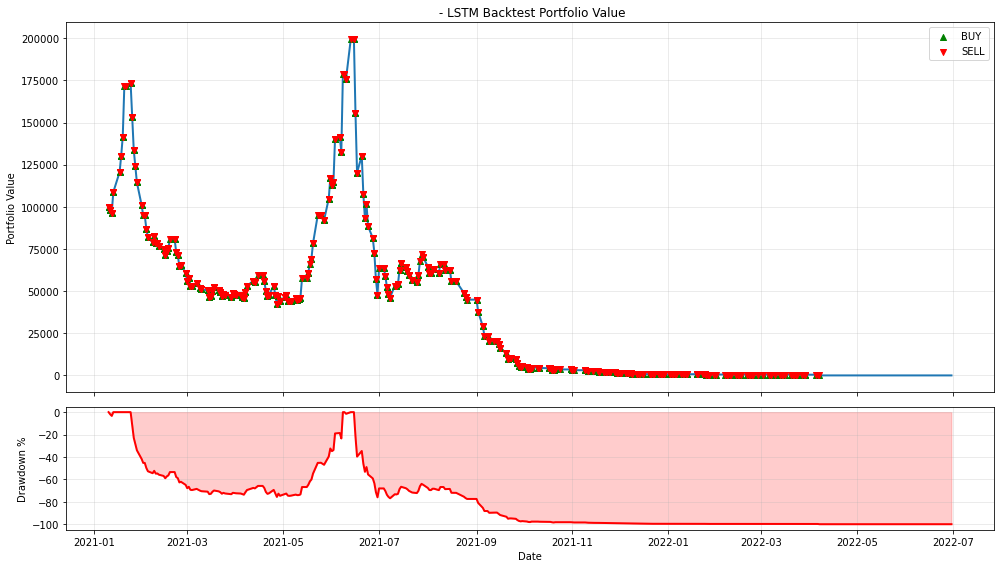


DETAILED STATISTICS
Trade Win Rate: 34.31% (292/851)
Maximum Drawdown: -99.99%
Sharpe Ratio (annualized): -2.89


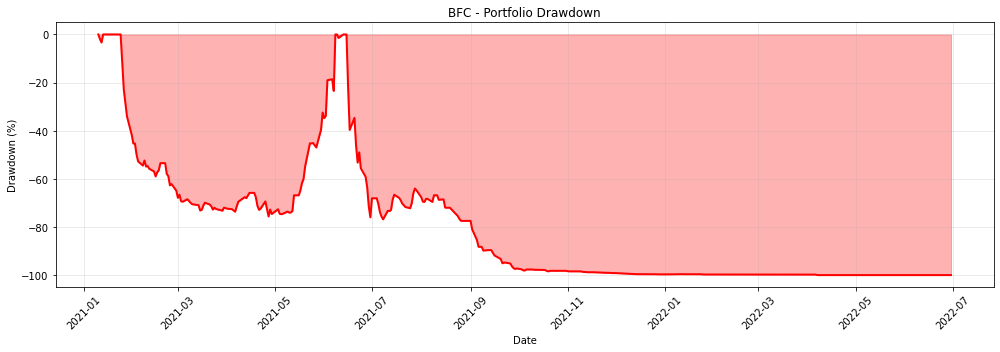


✓ Backtesting completed for BFC


In [13]:
# Run LSTM backtest
lstm_results = backtest_lstm_model(
    stock_symbol=stock_symbol_lstm,
    spark=spark,
    hdfs_base_path=hdfs_base_path,
    test_start_year=2021,
    test_end_year=2022,
    sequence_length=20,
    initial_capital=100000.0,
    position_size=0.95,
    transaction_cost=0.001
)

# Visualize results
visualize_lstm_backtest(lstm_results)

# Additional analysis
df_trades = pd.DataFrame(lstm_results['trades'])
df_portfolio = pd.DataFrame(lstm_results['portfolio_values'])

print(f"\n{'='*80}")
print("DETAILED STATISTICS")
print(f"{'='*80}")

# Win rate for trades
if len(df_trades) > 1:
    # Match buy-sell pairs
    buys = df_trades[df_trades['action'] == 'BUY']
    sells = df_trades[df_trades['action'] == 'SELL']
    
    winning_trades = 0
    total_pairs = min(len(buys), len(sells))
    
    for i in range(total_pairs):
        if sells.iloc[i]['price'] > buys.iloc[i]['price']:
            winning_trades += 1
    
    if total_pairs > 0:
        trade_win_rate = (winning_trades / total_pairs) * 100
        print(f"Trade Win Rate: {trade_win_rate:.2f}% ({winning_trades}/{total_pairs})")

# Drawdown analysis
df_portfolio['drawdown'] = (df_portfolio['portfolio_value'] / df_portfolio['portfolio_value'].cummax() - 1) * 100
max_drawdown = df_portfolio['drawdown'].min()
print(f"Maximum Drawdown: {max_drawdown:.2f}%")

# Sharpe ratio (simplified, assuming risk-free rate = 0)
returns = df_portfolio['portfolio_value'].pct_change().dropna()
sharpe = (returns.mean() / returns.std()) * np.sqrt(252) if returns.std() > 0 else 0
print(f"Sharpe Ratio (annualized): {sharpe:.2f}")

# Plot drawdown
plt.figure(figsize=(14, 5))
plt.plot(df_portfolio['date'], df_portfolio['drawdown'], linewidth=2, color='red')
plt.fill_between(df_portfolio['date'], df_portfolio['drawdown'], 0, alpha=0.3, color='red')
plt.xlabel('Date')
plt.ylabel('Drawdown (%)')
plt.title(f'{stock_symbol_lstm} - Portfolio Drawdown')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print(f"\n✓ Backtesting completed for {stock_symbol_lstm}")

# Sentiment analysis

In [15]:
from transformers import pipeline

news_headline = "Stocks rally as market optimism returns amid economic recovery signs."
pipe = pipeline("text-classification", model="mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis")
pipe(news_headline)

config.json:   0%|          | 0.00/933 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/328M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/333 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

[{'label': 'positive', 'score': 0.9995713829994202}]

## Cleanup

Finally, let's clean up our Spark session:

In [ ]:
# Stop the Spark session
spark.stop()

In [18]:
# reading kafka topic
# Install dependencies
!pip install kafka-python rich

# ---------------------------------------
# FULL DASHBOARD CODE + RUNNER IN 1 CELL
# ---------------------------------------

import os
import json
import signal
from datetime import datetime
from typing import Dict, List

from kafka import KafkaConsumer
from kafka.errors import KafkaError
from rich.console import Console
from rich.table import Table
from rich.live import Live

# ----------- ENVIRONMENT VARIABLES ------------
os.environ["KAFKA_BROKER"] = os.getenv("KAFKA_BROKER", "kafka:29092")
os.environ["TOPICS"] = os.getenv("TOPICS", "nepse-stream")
os.environ["DASHBOARD_POLL_MS"] = os.getenv("DASHBOARD_POLL_MS", "1000")
os.environ["DASHBOARD_REFRESH_PER_SECOND"] = os.getenv("DASHBOARD_REFRESH_PER_SECOND", "2")

KAFKA_BROKER = os.environ["KAFKA_BROKER"]
TOPICS = os.environ["TOPICS"]
POLL_TIMEOUT_MS = int(os.environ["DASHBOARD_POLL_MS"])
REFRESH_RATE = int(os.environ["DASHBOARD_REFRESH_PER_SECOND"])

console = Console(force_jupyter=True)  # better display inside Jupyter


# ------------- DASHBOARD CLASS -----------------
class NEPSELiveDashboard:
    def __init__(self, broker: str = KAFKA_BROKER, topics: str = TOPICS):
        self.broker = broker
        self.topics = [t.strip() for t in topics.split(",") if t.strip()]
        self.consumer: KafkaConsumer = None
        self.stocks: Dict[str, Dict] = {}
        self.running = True

    def connect(self):
        console.print(f"📡 Connecting to Kafka broker: {self.broker}")
        console.print(f"📋 Subscribing to topics: {', '.join(self.topics)}\n")
        try:
            self.consumer = KafkaConsumer(
                *self.topics,
                bootstrap_servers=[self.broker],
                value_deserializer=lambda m: json.loads(m.decode("utf-8")),
                auto_offset_reset="latest",
                enable_auto_commit=True,
                group_id="nepse-dashboard",
            )
            console.print("✅ Connected to Kafka!\n", style="bold green")
            return True
        except Exception as e:
            console.print(f"❌ Failed to create Kafka consumer: {e}", style="bold red")
            return False

    def stop(self):
        self.running = False
        try:
            if self.consumer:
                self.consumer.wakeup()
        except Exception:
            pass

    def update_stock(self, data: Dict):
        symbol = data.get("symbol")
        if symbol:
            self.stocks[symbol] = data

    def render_table(self) -> Table:
        table = Table(title=f"NEPSE Live Stock Dashboard ({len(self.stocks)} symbols)")
        table.add_column("Symbol", justify="left", style="cyan", no_wrap=True)
        table.add_column("Last Price", justify="right", style="yellow")
        table.add_column("% Change", justify="right")
        table.add_column("Volume", justify="right")

        sorted_stocks = sorted(
            self.stocks.values(),
            key=lambda x: float(x.get("percentageChange", 0) or 0),
            reverse=True,
        )

        for stock in sorted_stocks[:50]:
            symbol = stock.get("symbol", "N/A")
            price = stock.get("lastTradedPrice")
            change = stock.get("percentageChange", 0)
            vol = stock.get("totalTradeQuantity", 0)

            try:
                price_str = f"{float(price):,.2f}"
            except:
                price_str = str(price or "N/A")

            try:
                change_val = float(change)
                if change_val > 0:
                    change_str = f"[green]+{change_val:.2f}%[/green]"
                elif change_val < 0:
                    change_str = f"[red]{change_val:.2f}%[/red]"
                else:
                    change_str = f"{change_val:.2f}%"
            except:
                change_str = str(change)

            try:
                vol_str = f"{int(vol):,}"
            except:
                vol_str = str(vol or "N/A")

            table.add_row(symbol, price_str, change_str, vol_str)

        return table

    def run(self):
        if not self.connect():
            return

        console.print("Press Ctrl+C to stop\n", style="bold yellow")

        try:
            with Live(self.render_table(), refresh_per_second=REFRESH_RATE, console=console) as live:
                while self.running:
                    try:
                        records = self.consumer.poll(timeout_ms=POLL_TIMEOUT_MS)
                        if not records:
                            continue

                        for tp, msgs in records.items():
                            for message in msgs:
                                try:
                                    data = message.value
                                    if isinstance(data, dict):
                                        self.update_stock(data)
                                except:
                                    continue

                        live.update(self.render_table())

                    except KafkaError as ke:
                        console.print(f"Kafka error: {ke}", style="bold red")
                        break
                    except Exception as e:
                        if not self.running:
                            break
                        console.print(f"Unexpected error: {e}", style="bold red")
                        break

        finally:
            try:
                if self.consumer:
                    self.consumer.close()
            except:
                pass
            console.print("\n✅ Kafka connection closed", style="bold green")


# ------------- RUN THE DASHBOARD -----------------
dashboard = NEPSELiveDashboard()
dashboard.run()


     |████████████████████████████████| 326 kB 1.3 MB/s eta 0:00:01
     |████████████████████████████████| 243 kB 17.2 MB/s eta 0:00:01
     |████████████████████████████████| 1.2 MB 20.7 MB/s eta 0:00:01
     |████████████████████████████████| 87 kB 11.3 MB/s eta 0:00:01
  Attempting uninstall: pygments
    Found existing installation: Pygments 2.9.0
    Uninstalling Pygments-2.9.0:
      Successfully uninstalled Pygments-2.9.0


📡 Connecting to Kafka broker: kafka:29092

📋 Subscribing to topics: nepse-stream

✅ Connected to Kafka!

Press Ctrl+C to stop

Output()

✅ Kafka connection closed

KeyboardInterrupt: 

In [ ]:
import pandas as pd
from kafka import KafkaConsumer
import json
import time

KAFKA_BROKER = "kafka:29092"
TOPIC = "nepse-stream"

# Rolling last prices for each stock
stock_prices = {}

MIN_CANDLES = 5  # minimal for a simple swing approximation

print("🔄 Real-time Last Price Pattern Detector Started...")

consumer = KafkaConsumer(
    TOPIC,
    bootstrap_servers=[KAFKA_BROKER],
    value_deserializer=lambda x: json.loads(x.decode("utf-8")),
    auto_offset_reset='latest'
)

for msg in consumer:
    tick = msg.value
    symbol = tick.get("symbol")
    last_price = tick.get("lastTradedPrice")
    volume = tick.get("totalTradeQuantity")  # or tick.get("lastTradedVolume")

    if symbol is None or last_price is None:
        print(f"⚠️  Skipping tick due to missing symbol or lastTradedPrice: {tick}")
        continue

    # Initialize list for storing last prices
    if symbol not in stock_prices:
        stock_prices[symbol] = []

    # Append the latest price
    stock_prices[symbol].append(float(last_price))

    # Keep only last 50 prices
    stock_prices[symbol] = stock_prices[symbol][-50:]
    prices = stock_prices[symbol]

    # Log tick info
    print(f"\n📊 Tick received: Symbol={symbol}, Last Price={last_price}, Volume={volume}")
    print(f"📈 Rolling prices for {symbol}: {prices}")

    if len(prices) < MIN_CANDLES:
        print(f"⏳ Not enough data yet for pattern detection ({len(prices)}/{MIN_CANDLES} candles)")
        continue

    # Simple pattern: swing high then pullback
    swing_high = max(prices[:-1])
    current_price = prices[-1]
    retracement = (swing_high - current_price) / swing_high

    # Log computed values
    print(f"🔍 Computed swing high: {swing_high}")
    print(f"🔍 Current price: {current_price}")
    print(f"🔍 Retracement: {retracement:.2%}")

    # Check Fibonacci retracement levels: 38.2%, 50%, 61.8%
    if 0.382 <= retracement <= 0.618:
        print(f"\n🎯 {symbol} retraced to key Fibonacci level")
        print(f"🟢 BUY signal at {current_price}")
        print(f"Swing High: {swing_high}, Current Price: {current_price}, Retracement: {retracement:.2%}")
    else:
        print(f"⏳ {symbol}: No pattern detected (retracement {retracement:.2%} not in 38.2%-61.8%)")


🔄 Real-time Last Price Pattern Detector Started...



📊 Tick received: Symbol=BANDIPUR, Last Price=825, Volume=227147
📈 Rolling prices for BANDIPUR: [825.0]
⏳ Not enough data yet for pattern detection (1/5 candles)

📊 Tick received: Symbol=NRIC, Last Price=1315, Volume=58828
📈 Rolling prices for NRIC: [1315.0]
⏳ Not enough data yet for pattern detection (1/5 candles)

📊 Tick received: Symbol=NLIC, Last Price=829, Volume=75475
📈 Rolling prices for NLIC: [829.0]
⏳ Not enough data yet for pattern detection (1/5 candles)

📊 Tick received: Symbol=UMHL, Last Price=589.9, Volume=158142
📈 Rolling prices for UMHL: [589.9]
⏳ Not enough data yet for pattern detection (1/5 candles)

📊 Tick received: Symbol=DHEL, Last Price=622.3, Volume=105304
📈 Rolling prices for DHEL: [622.3]
⏳ Not enough data yet for pattern detection (1/5 candles)

📊 Tick received: Symbol=TTL, Last Price=827, Volume=126477
📈 Rolling prices for TTL: [827.0]
⏳ Not enough data yet for pattern detection (1/5 candles)

📊 Tick received: Symbol=SPDL, Last Price=421, Volume=108976
📈 Rol

KeyboardInterrupt: 